## 1. 필요한 라이브러리 임포트 및 환경 설정

In [1]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.oauth2 import service_account
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# matplotlib 한글 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

## 2. BigQuery 연결

In [2]:
# BigQuery 클라이언트 초기화
def get_bigquery_client():
    service_account_path = "/Users/cg01-piwoo/my_quant/access_info/data/quantsungyong-663604552de9.json"
    credentials = service_account.Credentials.from_service_account_file(
        service_account_path,
        scopes=["https://www.googleapis.com/auth/cloud-platform"]
    )
    return bigquery.Client(credentials=credentials, project=credentials.project_id)

client = get_bigquery_client()


# ADX와 Chaikin 지표를 포함한 데이터 로드 함수
def get_stock_data_with_indicators(ticker, start_date=None, end_date=None):
    date_conditions = []
    if start_date:
        date_conditions.append(f"JSON_EXTRACT_SCALAR(r.dates_array[OFFSET(i.pos)], '$') >= '{start_date}'")
    if end_date:
        date_conditions.append(f"JSON_EXTRACT_SCALAR(r.dates_array[OFFSET(i.pos)], '$') <= '{end_date}'")
    
    date_filter = f"AND {' AND '.join(date_conditions)}" if date_conditions else ""
    
    query = f"""
    WITH raw_data AS (
      SELECT 
        ticker,
        -- 가격 데이터
        JSON_EXTRACT_ARRAY(data, '$.dates') AS dates_array,
        JSON_EXTRACT_ARRAY(data, '$.open') AS open_array,
        JSON_EXTRACT_ARRAY(data, '$.high') AS high_array,
        JSON_EXTRACT_ARRAY(data, '$.low') AS low_array,
        JSON_EXTRACT_ARRAY(data, '$.close') AS close_array,
        JSON_EXTRACT_ARRAY(data, '$.volume') AS volume_array,
        
        -- ADX 관련 지표
        JSON_EXTRACT_ARRAY(data, '$.adx_14_values') AS adx_14_values_array,
        JSON_EXTRACT_ARRAY(data, '$.pdi_14_values') AS pdi_14_values_array,
        JSON_EXTRACT_ARRAY(data, '$.mdi_14_values') AS mdi_14_values_array,
        
        -- Chaikin Oscillator 관련 지표 (수정된 필드명)
        JSON_EXTRACT_ARRAY(data, '$.chaikin_oscillator') AS chaikin_oscillator_array,
        JSON_EXTRACT_ARRAY(data, '$.chaikin_9_signal_line') AS chaikin_signal_array,

        -- MACD 관련
        JSON_EXTRACT_ARRAY(data, '$.macd_line') AS macd_line_array,
        JSON_EXTRACT_ARRAY(data, '$.macd_9_signal_line') AS macd_9_signal_line_array,
        JSON_EXTRACT_ARRAY(data, '$.macd_histogram') AS macd_histogram_array,
        JSON_EXTRACT_ARRAY(data, '$.macd_signals') AS macd_signals_array,
        
        -- Stochastic
        JSON_EXTRACT_ARRAY(data, '$.stochastic_k_line') AS stochastic_k_line_array,
        JSON_EXTRACT_ARRAY(data, '$.stochastic_d_line') AS stochastic_d_line_array,
        
        -- OBV 관련
        JSON_EXTRACT_ARRAY(data, '$.obv_values') AS obv_values_array,
        JSON_EXTRACT_ARRAY(data, '$.obv_9_ma') AS obv_9_ma_array,
        JSON_EXTRACT_ARRAY(data, '$.obv_signals') AS obv_signals_array,

        -- RSI 관련
        JSON_EXTRACT_ARRAY(data, '$.rsi_14_values') AS rsi_14_values_array,
        JSON_EXTRACT_ARRAY(data, '$.rsi_9_signal_line') AS rsi_9_signal_line_array,
        JSON_EXTRACT_ARRAY(data, '$.rsi_histogram') AS rsi_histogram_array,
        JSON_EXTRACT_ARRAY(data, '$.rsi_signals') AS rsi_signals_array,
              
        -- ATR 관련 지표
        JSON_EXTRACT_ARRAY(data, '$.atr') AS atr_array,

        -- 배열 길이
        ARRAY_LENGTH(JSON_EXTRACT_ARRAY(data, '$.close')) AS array_length
        
      FROM 
        `quantsungyong.finviz_data.stock_data_with_indicators`
      WHERE 
        ticker = '{ticker}'
    ),
    indices AS (
      SELECT r.ticker, pos
      FROM raw_data r,
      UNNEST(GENERATE_ARRAY(0, r.array_length - 1)) AS pos
    )
    SELECT 
      -- 날짜와 가격 데이터
      JSON_EXTRACT_SCALAR(r.dates_array[OFFSET(i.pos)], '$') AS date,
      CAST(JSON_EXTRACT_SCALAR(r.open_array[OFFSET(i.pos)], '$') AS FLOAT64) AS open,
      CAST(JSON_EXTRACT_SCALAR(r.high_array[OFFSET(i.pos)], '$') AS FLOAT64) AS high,
      CAST(JSON_EXTRACT_SCALAR(r.low_array[OFFSET(i.pos)], '$') AS FLOAT64) AS low,
      CAST(JSON_EXTRACT_SCALAR(r.close_array[OFFSET(i.pos)], '$') AS FLOAT64) AS close,
      CAST(JSON_EXTRACT_SCALAR(r.volume_array[OFFSET(i.pos)], '$') AS INT64) AS volume,
      
      -- RSI 관련
      CASE 
        WHEN ARRAY_LENGTH(r.rsi_14_values_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.rsi_14_values_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS rsi_14,
      
      CASE 
        WHEN ARRAY_LENGTH(r.rsi_9_signal_line_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.rsi_9_signal_line_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS rsi_9_signal_line,
      
      CASE 
        WHEN ARRAY_LENGTH(r.rsi_histogram_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.rsi_histogram_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS rsi_histogram,
      
      CASE 
        WHEN ARRAY_LENGTH(r.rsi_signals_array) > i.pos 
        THEN JSON_EXTRACT_SCALAR(r.rsi_signals_array[OFFSET(i.pos)], '$')
        ELSE NULL 
      END AS rsi_signals,
      
      CASE 
        WHEN ARRAY_LENGTH(r.macd_9_signal_line_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.macd_9_signal_line_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS macd_9_signal_line,
      
      CASE 
        WHEN ARRAY_LENGTH(r.macd_histogram_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.macd_histogram_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS macd_histogram,
      
      CASE 
        WHEN ARRAY_LENGTH(r.macd_signals_array) > i.pos 
        THEN JSON_EXTRACT_SCALAR(r.macd_signals_array[OFFSET(i.pos)], '$')
        ELSE NULL 
      END AS macd_signals,
      
      
      -- ATR 관련 지표
      CASE 
        WHEN ARRAY_LENGTH(r.atr_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.atr_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS atr,
      -- ADX 관련 지표
      CASE 
        WHEN ARRAY_LENGTH(r.adx_14_values_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.adx_14_values_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS adx_14,
      
      CASE 
        WHEN ARRAY_LENGTH(r.pdi_14_values_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.pdi_14_values_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS pdi_14,
      
      CASE 
        WHEN ARRAY_LENGTH(r.mdi_14_values_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.mdi_14_values_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS mdi_14,
      
      -- Chaikin Oscillator (수정된 필드명)
      CASE 
        WHEN ARRAY_LENGTH(r.chaikin_oscillator_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.chaikin_oscillator_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS chaikin_oscillator,
      
      CASE 
        WHEN ARRAY_LENGTH(r.chaikin_signal_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.chaikin_signal_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS chaikin_signal,

      -- Stochastic
      CASE 
        WHEN ARRAY_LENGTH(r.stochastic_k_line_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.stochastic_k_line_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS stochastic_k_line,
      
      CASE 
        WHEN ARRAY_LENGTH(r.stochastic_d_line_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.stochastic_d_line_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS stochastic_d_line,

      -- MACD 관련
      CASE 
        WHEN ARRAY_LENGTH(r.macd_line_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.macd_line_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS macd_line,
      
      CASE 
        WHEN ARRAY_LENGTH(r.macd_9_signal_line_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.macd_9_signal_line_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS macd_9_signal_line,
      
      CASE 
        WHEN ARRAY_LENGTH(r.macd_histogram_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.macd_histogram_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS macd_histogram,
      
      CASE 
        WHEN ARRAY_LENGTH(r.macd_signals_array) > i.pos 
        THEN JSON_EXTRACT_SCALAR(r.macd_signals_array[OFFSET(i.pos)], '$')
        ELSE NULL 
      END AS macd_signals,
      
      -- OBV 관련
      CASE 
        WHEN ARRAY_LENGTH(r.obv_values_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.obv_values_array[OFFSET(i.pos)], '$') AS INT64)
        ELSE NULL 
      END AS obv_values,
      
      CASE 
        WHEN ARRAY_LENGTH(r.obv_9_ma_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.obv_9_ma_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS obv_9_ma,
      
      CASE 
        WHEN ARRAY_LENGTH(r.obv_signals_array) > i.pos 
        THEN JSON_EXTRACT_SCALAR(r.obv_signals_array[OFFSET(i.pos)], '$')
        ELSE NULL 
      END AS obv_signals

    FROM raw_data r
    CROSS JOIN indices i
    WHERE i.ticker = r.ticker {date_filter}
    ORDER BY date DESC
    """
    
    try:
        df = client.query(query).to_dataframe()
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        df.sort_index(inplace=True)
        # Chaikin의 전일 값 계산
        df['chaikin_yesterday'] = df['chaikin_oscillator'].shift(1)

        print(f"✅ {ticker} 데이터 로드 완료: {len(df)}개 레코드")
        return df
    except Exception as e:
        print(f"❌ 데이터 로드 실패: {e}")
        return None

## 3. ATR 기반 백테스트 전략 함수 정의

### 함수1

In [22]:
# ATR 계산 함수
def calculate_atr(df, period=14):
    """
    ATR (Average True Range) 계산
    
    Parameters:
    - df: DataFrame with 'high', 'low', 'close' columns
    - period: ATR 계산 기간 (기본 14)
    
    Returns:
    - Series: ATR values
    """
    # True Range 계산
    high_low = df['high'].shift(1) - df['low'].shift(1)
    high_close = np.abs(df['high'].shift(1) - df['close'].shift(2))
    low_close = np.abs(df['low'].shift(1) - df['close'].shift(2))
    
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    
    # ATR 계산 (단순이동평균)
    atr = tr.rolling(window=period).mean()
    
    return atr


### 함수2 : 매수매도

In [109]:
def backtest_atr_strategy(ticker, df, initial_capital=100000, 
                         atr_entry_multiplier=0.5,  # ATR의 몇 배 이상 움직이면 매수
                         stop_loss_atr=1.5,         # 손절선: ATR의 몇 배
                         take_profit_atr=3.0,       # 익절선: ATR의 몇 배
                         position_size_atr=2.0,     # 포지션 사이징: 자본금의 2%를 ATR 1배로 나눔
                         commission_rate=0.001,     # 거래수수료 0.1%
                         slippage_rate=0.001,      # 슬리피지 0.1%
                         atr_period=14,            # ATR 계산 기간
                         capital_ratio=0.5,
                         position_sizing=0.02):
    """
    ATR 기반 변동성 돌파 전략 백테스트
    
    매수 조건 (현실적인 접근):
    1. 어제 ATR 기반으로 오늘 변동성 돌파 가격 설정
    2. 돌파가격 = 오늘 시가 + (어제 ATR * multiplier)
    3. 오늘 고가가 돌파가격을 상향 돌파하면 매수
    
    포지션 사이징:
    - 리스크 = 자본금의 2%
    - 포지션 크기 = 리스크 / (ATR * stop_loss_atr)
    
    청산 조건:
    1. 손절: 매수가 - (ATR * stop_loss_atr)
    2. 익절: 매수가 + (ATR * take_profit_atr)
    """
    
    # ATR 계산 (calculate_atr 함수 사용)
    df = df.copy()  # 원본 데이터프레임 보호
    df['atr'] = calculate_atr(df, period=atr_period)
    
    # 전일 ATR 추가
    df['prev_atr'] = df['atr'].shift(1)
    
    # 백테스트 결과 저장용 변수
    cash = initial_capital
    position = 0
    entry_price = 0
    entry_atr = 0
    trades = []
    
    # 일별 수익률 및 포트폴리오 가치
    portfolio_values = []
    daily_returns = []
    positions = []  # 매일의 포지션 수
    
    for i in range(len(df)):
        date = df.index[i]
        row = df.iloc[i]
        
        # 첫날이거나 전일 ATR이 없으면 스킵
        if i == 0 or pd.isna(row['prev_atr']) or row['prev_atr'] <= 0:
            portfolio_value = cash + (position * row['close'] if position > 0 else 0)
            portfolio_values.append(portfolio_value)
            daily_returns.append(0)
            positions.append(position)
            continue
        
        # 포지션이 없을 때 - 진입 조건 확인
        if position == 0:
            # 변동성 돌파 가격 계산 (어제 ATR 기반)
            breakout_price = row['open'] + (row['prev_atr'] * atr_entry_multiplier)
            
            # 오늘 고가가 돌파 가격을 넘으면 매수
            if row['high'] > breakout_price:
                # 실제 매수가는 돌파 가격 (더 현실적)
                buy_price = breakout_price * (1 + slippage_rate)
                
                # 매수가가 오늘 고가를 넘으면 고가로 제한
                buy_price = min(buy_price, row['high'])
                
                # 포지션 사이징
                risk_amount = cash * position_sizing  # 자본금의 2%
                stop_loss_distance = row['prev_atr'] * stop_loss_atr
                position_value = risk_amount / stop_loss_distance * buy_price
                
                # 최대 자본금의 50%까지만 사용
                position_value = min(position_value, cash * capital_ratio)
                
                # 매수 실행
                shares = int(position_value / buy_price)
                
                if shares > 0 and shares * buy_price <= cash:
                    position = shares
                    entry_price = buy_price
                    entry_atr = row['prev_atr']  # 어제 ATR 기록
                    cash -= shares * buy_price * (1 + commission_rate)
                    
                    trades.append({
                        'ticker': ticker,
                        'entry_date': date,
                        'entry_price': entry_price,
                        'shares': shares,
                        'entry_atr': entry_atr,
                        'stop_loss': entry_price - (entry_atr * stop_loss_atr),
                        'take_profit': entry_price + (entry_atr * take_profit_atr),
                        'position_value': shares * entry_price,
                        'breakout_price': breakout_price
                    })
        
        # 포지션이 있을 때 - 청산 조건 확인
        else:
            stop_loss = entry_price - (entry_atr * stop_loss_atr)
            take_profit = entry_price + (entry_atr * take_profit_atr)
            
            exit_signal = False
            exit_reason = ""
            exit_price = 0
            
            # 손절 확인
            if row['low'] <= stop_loss:
                exit_price = stop_loss * (1 - slippage_rate)
                exit_signal = True
                exit_reason = "stop_loss"
            # 익절 확인
            elif row['high'] >= take_profit:
                exit_price = take_profit * (1 - slippage_rate)
                exit_signal = True
                exit_reason = "take_profit"
            
            # 청산 실행
            if exit_signal:
                # 실제 체결 가능한 가격으로 조정
                if exit_reason == "stop_loss":
                    exit_price = max(exit_price, row['low'])
                elif exit_reason == "take_profit":
                    exit_price = min(exit_price, row['high'])
                
                cash += position * exit_price * (1 - commission_rate)
                
                # 거래 기록 업데이트
                trades[-1].update({
                    'exit_date': date,
                    'exit_price': exit_price,
                    'exit_reason': exit_reason,
                    'return': (exit_price - entry_price) / entry_price,
                    'profit_loss': position * (exit_price - entry_price)
                })
                
                position = 0
                entry_price = 0
                entry_atr = 0
        
        # 포트폴리오 가치 계산
        portfolio_value = cash + (position * row['close'] if position > 0 else 0)
        portfolio_values.append(portfolio_value)
        
        # 일별 수익률 계산
        if i > 0:
            daily_return = (portfolio_value - portfolio_values[i-1]) / portfolio_values[i-1]
            daily_returns.append(daily_return)
        else:
            daily_returns.append(0)
        
        positions.append(position)
    
    # 마지막에 포지션이 남아있다면 청산
    if position > 0:
        final_price = df.iloc[-1]['close'] * (1 - slippage_rate)
        cash += position * final_price * (1 - commission_rate)
        
        trades[-1].update({
            'exit_date': df.index[-1],
            'exit_price': final_price,
            'exit_reason': 'end_of_period',
            'return': (final_price - entry_price) / entry_price,
            'profit_loss': position * (final_price - entry_price)
        })
        
        portfolio_values[-1] = cash
    
    # 결과 DataFrame 생성
    trades_df = pd.DataFrame(trades)
    
    # 포트폴리오 DataFrame 생성 (추가 필드 포함)
    portfolio_df = pd.DataFrame({
        'date': df.index,
        'portfolio_value': portfolio_values,
        'daily_returns': daily_returns,
        'position': positions,
        'close': df['close'].values,
        'atr': df['atr'].values
    })
    portfolio_df.set_index('date', inplace=True)
    
    # 누적 수익률 계산
    portfolio_df['cumulative_returns'] = (1 + portfolio_df['daily_returns']).cumprod()
    
    # Buy & Hold 수익률 계산
    portfolio_df['buy_hold_returns'] = portfolio_df['close'] / portfolio_df['close'].iloc[0]
    
    # 전략 vs Buy & Hold 비교
    portfolio_df['strategy_vs_buyhold'] = portfolio_df['cumulative_returns'] / portfolio_df['buy_hold_returns']
    
    return trades_df, portfolio_df

### 함수3 : 결과분석

In [101]:
def analyze_backtest_results(trades_df, portfolio_df, initial_capital=100000):
    """백테스트 결과 분석"""
    
    results = {}
    
    # 기본 통계
    results['total_trades'] = len(trades_df)
    results['initial_capital'] = initial_capital
    results['final_portfolio_value'] = portfolio_df['portfolio_value'].iloc[-1]
    results['total_return'] = (results['final_portfolio_value'] - initial_capital) / initial_capital
    
    # CAGR 계산
    start_date = portfolio_df.index[0]
    end_date = portfolio_df.index[-1]
    years = (end_date - start_date).days / 365.25
    results['cagr'] = (results['final_portfolio_value'] / initial_capital) ** (1 / years) - 1
    
    if len(trades_df) > 0:
        completed_trades = trades_df[trades_df['exit_date'].notna()]
        
        if len(completed_trades) > 0:
            # 승률
            winning_trades = completed_trades[completed_trades['profit_loss'] > 0]
            results['win_rate'] = len(winning_trades) / len(completed_trades)
            
            # 평균 수익률
            results['avg_return'] = completed_trades['return'].mean()
            results['avg_win'] = winning_trades['return'].mean() if len(winning_trades) > 0 else 0
            results['avg_loss'] = completed_trades[completed_trades['profit_loss'] <= 0]['return'].mean()
            
            # 손익비
            if results['avg_loss'] != 0:
                results['profit_factor'] = abs(results['avg_win'] / results['avg_loss'])
            else:
                results['profit_factor'] = float('inf') if results['avg_win'] > 0 else 0
            
            # 청산 이유별 통계
            results['exit_reasons'] = completed_trades['exit_reason'].value_counts().to_dict()
    
    # 최대 낙폭 (MDD)
    cummax = portfolio_df['portfolio_value'].cummax()
    drawdown = (portfolio_df['portfolio_value'] - cummax) / cummax
    results['max_drawdown'] = drawdown.min()
    
    # 일별 수익률 사용 (portfolio_df에 이미 있음)
    daily_returns = portfolio_df['daily_returns'].dropna()
    
    if len(daily_returns) > 0:
        # 샤프비율 (연환산, 무위험수익률 2%)
        results['sharpe_ratio'] = (daily_returns.mean() * 252 - 0.02) / (daily_returns.std() * np.sqrt(252))
        
        # 소르티노 비율 (하방 변동성만 고려, 무위험수익률 2%)
        # 목표 수익률을 무위험 수익률로 설정
        target_return = 0.02 / 252  # 일별 목표 수익률
        downside_returns = daily_returns[daily_returns < target_return] - target_return
        
        if len(downside_returns) > 0:
            downside_std = np.sqrt((downside_returns ** 2).mean())
            results['sortino_ratio'] = (daily_returns.mean() * 252 - 0.02) / (downside_std * np.sqrt(252))
        else:
            # 손실이 없는 경우
            results['sortino_ratio'] = float('inf') if daily_returns.mean() > 0 else 0
    else:
        results['sharpe_ratio'] = 0
        results['sortino_ratio'] = 0
    
    return results

### 함수4 - 포트폴리오 통합 성과 분석

In [146]:
def portfolio_integrated_backtest(stock_data_dict, initial_capital=100000,
                                atr_entry_multiplier=0.5,
                                stop_loss_atr=1.5,
                                take_profit_atr=3.0,
                                position_size_atr=2.0,
                                commission_rate=0.001,
                                slippage_rate=0.001,
                                atr_period=14,
                                allocation_method='equal',
                                position_sizing=0.02,
                                capital_ratio=0.5):
    """
    포트폴리오 통합 백테스트
    
    여러 종목을 동시에 운용하는 포트폴리오의 통합 성과를 분석
    
    Parameters:
    - stock_data_dict: {ticker: df} 형태의 딕셔너리
    - allocation_method: 'equal' (균등 배분) 또는 'volatility_weighted' (변동성 가중)
    
    Returns:
    - all_trades_df: 모든 종목의 거래 내역
    - integrated_portfolio_df: 통합 포트폴리오 성과
    - ticker_allocation: 종목별 자금 배분 비율
    """
    
    # 종목 수와 종목별 초기 자본 설정
    n_tickers = len(stock_data_dict)
    
    if allocation_method == 'equal':
        # 균등 배분
        ticker_capital = {ticker: initial_capital / n_tickers for ticker in stock_data_dict.keys()}
    else:
        # 변동성 가중 배분 (ATR 역수 비례)
        avg_atrs = {}
        for ticker, df in stock_data_dict.items():
            df_copy = df.copy()
            df_copy['atr'] = calculate_atr(df_copy, period=atr_period)
            avg_atrs[ticker] = df_copy['atr'].mean()
        
        # ATR 역수로 가중치 계산
        weights = {ticker: 1/atr for ticker, atr in avg_atrs.items()}
        total_weight = sum(weights.values())
        ticker_capital = {ticker: (weight/total_weight) * initial_capital 
                         for ticker, weight in weights.items()}
    
    # 종목별 백테스트 실행
    ticker_results = {}
    all_trades = []
    
    for ticker, df in stock_data_dict.items():
        trades_df, portfolio_df = backtest_atr_strategy(
            ticker, df, 
            ticker_capital[ticker],  # 종목별 할당 자본
            atr_entry_multiplier=atr_entry_multiplier,
            stop_loss_atr=stop_loss_atr,
            take_profit_atr=take_profit_atr,
            position_size_atr=position_size_atr,
            commission_rate=commission_rate,
            slippage_rate=slippage_rate,
            atr_period=atr_period,
            position_sizing=position_sizing,
            capital_ratio=capital_ratio  # 종목별 최대 자본금 비율
        )
        
        # 결과 저장
        ticker_results[ticker] = {
            'trades_df': trades_df,
            'portfolio_df': portfolio_df,
            'allocation': ticker_capital[ticker] / initial_capital
        }
        
        if len(trades_df) > 0:
            trades_df['allocation'] = ticker_capital[ticker] / initial_capital
            all_trades.append(trades_df)
    
    # 통합 포트폴리오 생성
    # 모든 날짜 범위 찾기
    all_dates = set()
    for ticker, results in ticker_results.items():
        all_dates.update(results['portfolio_df'].index)
    all_dates = sorted(list(all_dates))
    
    # 일별 통합 포트폴리오 가치 계산
    integrated_values = []
    integrated_returns = []
    ticker_values = {ticker: [] for ticker in stock_data_dict.keys()}
    
    for date in all_dates:
        daily_total = 0
        daily_ticker_values = {}
        
        for ticker, results in ticker_results.items():
            portfolio_df = results['portfolio_df']
            if date in portfolio_df.index:
                value = portfolio_df.loc[date, 'portfolio_value']
            else:
                # 해당 날짜에 데이터가 없으면 가장 가까운 이전 값 사용
                prev_dates = portfolio_df.index[portfolio_df.index <= date]
                if len(prev_dates) > 0:
                    value = portfolio_df.loc[prev_dates[-1], 'portfolio_value']
                else:
                    value = ticker_capital[ticker]  # 초기 자본
            
            daily_total += value
            daily_ticker_values[ticker] = value
            ticker_values[ticker].append(value)
        
        integrated_values.append(daily_total)
        
        # 일별 수익률 계산
        if len(integrated_values) > 1:
            daily_return = (integrated_values[-1] - integrated_values[-2]) / integrated_values[-2]
        else:
            daily_return = 0
        integrated_returns.append(daily_return)
    
    # 통합 포트폴리오 DataFrame 생성
    integrated_portfolio_df = pd.DataFrame({
        'date': all_dates,
        'portfolio_value': integrated_values,
        'daily_returns': integrated_returns
    })
    integrated_portfolio_df.set_index('date', inplace=True)
    
    # 종목별 포트폴리오 가치 추가
    for ticker in stock_data_dict.keys():
        integrated_portfolio_df[f'{ticker}_value'] = ticker_values[ticker]
    
    # 누적 수익률 계산
    integrated_portfolio_df['cumulative_returns'] = (1 + integrated_portfolio_df['daily_returns']).cumprod()
    
    # Buy & Hold 수익률 계산 (각 종목의 Buy & Hold 가중 평균) - 타입 변환 수정
    integrated_portfolio_df['buy_hold_returns'] = 0.0  # float로 초기화
    for ticker, results in ticker_results.items():
        portfolio_df = results['portfolio_df']
        allocation = results['allocation']
        
        # 해당 종목의 Buy & Hold 수익률에 배분 비율을 곱해서 더함
        for date in integrated_portfolio_df.index:
            if date in portfolio_df.index:
                bh_return = float(portfolio_df.loc[date, 'buy_hold_returns'])  # float로 변환
                integrated_portfolio_df.loc[date, 'buy_hold_returns'] += bh_return * allocation
    
    # 전략 vs Buy & Hold
    integrated_portfolio_df['strategy_vs_buyhold'] = (
        integrated_portfolio_df['cumulative_returns'] / integrated_portfolio_df['buy_hold_returns']
    )
    
    # 종목별 비중 계산
    for ticker in stock_data_dict.keys():
        integrated_portfolio_df[f'{ticker}_weight'] = (
            integrated_portfolio_df[f'{ticker}_value'] / integrated_portfolio_df['portfolio_value']
        )
    
    # 모든 거래 통합
    if all_trades:
        all_trades_df = pd.concat(all_trades, ignore_index=True)
    else:
        all_trades_df = pd.DataFrame()
    
    # 통합 성과 분석
    integrated_results = analyze_backtest_results(
        all_trades_df, integrated_portfolio_df, initial_capital
    )
    
    return all_trades_df, integrated_portfolio_df, ticker_results, integrated_results

### 함수5 - 상대모멘텀 전략

In [129]:
def relative_momentum_portfolio_selection(all_results, portfolio_results, 
                                        lookback_period=20,  # 모멘텀 계산 기간 (일)
                                        top_n=3,  # 선택할 상위 종목 수
                                        rebalance_freq='monthly',  # 리밸런싱 주기
                                        initial_capital=100000):
    """
    ATR 전략의 수익률을 기반으로 상대모멘텀 포트폴리오 구성
    
    1. 각 종목의 ATR 전략 수익률을 기반으로 모멘텀 점수 계산
    2. 상위 N개 종목을 선택하여 균등 배분
    3. 정기적으로 리밸런싱
    
    Parameters:
    - all_results: 각 종목의 ATR 전략 백테스트 결과 (딕셔너리)
    - portfolio_results: 각 종목의 portfolio_df (딕셔너리)
    - lookback_period: 모멘텀 계산 기간
    - top_n: 선택할 종목 수
    - rebalance_freq: 리밸런싱 주기
    
    Returns:
    - momentum_portfolio_df: 상대모멘텀 포트폴리오 성과
    - selected_tickers_history: 시간별 선택된 종목 기록
    - momentum_scores_history: 시간별 모멘텀 점수 기록
    """
    
    # 모든 날짜 범위 찾기
    all_dates = set()
    for ticker, portfolio_df in portfolio_results.items():
        all_dates.update(portfolio_df.index)
    all_dates = sorted(list(all_dates))
    
    # 리밸런싱 날짜 설정
    if rebalance_freq == 'monthly':
        rebalance_dates = []
        current_month = None
        for date in all_dates:
            if current_month != date.month:
                rebalance_dates.append(date)
                current_month = date.month
    elif rebalance_freq == 'weekly':
        rebalance_dates = [date for date in all_dates if date.weekday() == 0]
    else:  # daily
        rebalance_dates = all_dates
    
    # 결과 저장용
    selected_tickers_history = {}
    momentum_scores_history = {}
    portfolio_values = []
    daily_returns = []
    ticker_weights = {}  # 종목별 비중 기록
    
    # 현재 선택된 종목과 비중
    current_selected_tickers = []
    ticker_allocations = {}
    portfolio_value = initial_capital  # 초기 자본금
    
    for i, date in enumerate(all_dates):
        # 리밸런싱 날짜인지 확인
        if date in rebalance_dates and i >= lookback_period:
            # 각 종목의 모멘텀 점수 계산 (ATR 전략 수익률 기반)
            momentum_scores = {}
            
            for ticker, portfolio_df in portfolio_results.items():
                if date in portfolio_df.index:
                    current_idx = portfolio_df.index.get_loc(date)
                    if current_idx >= lookback_period:
                        # lookback_period 동안의 ATR 전략 수익률
                        past_idx = current_idx - lookback_period
                        past_value = portfolio_df.iloc[past_idx]['portfolio_value']
                        current_value = portfolio_df.loc[date, 'portfolio_value']
                        momentum = (current_value - past_value) / past_value
                        momentum_scores[ticker] = momentum
            
            momentum_scores_history[date] = momentum_scores.copy()
            
            # 상위 N개 종목 선택
            if len(momentum_scores) >= top_n:
                sorted_tickers = sorted(momentum_scores.items(), key=lambda x: x[1], reverse=True)
                current_selected_tickers = [ticker for ticker, score in sorted_tickers[:top_n]]
                selected_tickers_history[date] = current_selected_tickers
                
                # 균등 배분
                equal_weight = 1.0 / top_n
                ticker_allocations = {ticker: equal_weight if ticker in current_selected_tickers else 0 
                                    for ticker in portfolio_results.keys()}
        
        # 포트폴리오 가치 계산 (수정된 로직)
        if i > 0:
            daily_value_change = 0
            total_weight = 0
            
            # 선택된 종목들의 일별 수익률을 가중 평균
            for ticker in current_selected_tickers:
                if ticker in portfolio_results and date in portfolio_results[ticker].index:
                    ticker_portfolio = portfolio_results[ticker]
                    
                    # 이전 날짜 찾기
                    prev_date = all_dates[i-1]
                    if prev_date in ticker_portfolio.index:
                        weight = ticker_allocations.get(ticker, 0)
                        
                        # 해당 종목의 일별 수익률 계산
                        prev_value = ticker_portfolio.loc[prev_date, 'portfolio_value']
                        curr_value = ticker_portfolio.loc[date, 'portfolio_value']
                        ticker_daily_return = (curr_value - prev_value) / prev_value
                        
                        # 가중 수익률 누적
                        daily_value_change += weight * ticker_daily_return
                        total_weight += weight
            
            # 포트폴리오 가치 업데이트
            if total_weight > 0:
                portfolio_value = portfolio_value * (1 + daily_value_change)
            
            # 일별 수익률
            daily_return = daily_value_change
        else:
            daily_return = 0
        
        portfolio_values.append(portfolio_value)
        daily_returns.append(daily_return)
        
        # 종목별 비중 기록
        ticker_weights[date] = ticker_allocations.copy()
    
    # 결과 DataFrame 생성
    momentum_portfolio_df = pd.DataFrame({
        'date': all_dates,
        'portfolio_value': portfolio_values,
        'daily_returns': daily_returns
    })
    momentum_portfolio_df.set_index('date', inplace=True)
    
    # 누적 수익률
    momentum_portfolio_df['cumulative_returns'] = momentum_portfolio_df['portfolio_value'] / initial_capital
    
    # Buy & Hold 벤치마크 (모든 종목 균등 투자 ATR 전략)
    momentum_portfolio_df['buy_hold_returns'] = 0.0
    n_tickers = len(portfolio_results)
    for ticker, portfolio_df in portfolio_results.items():
        weight = 1.0 / n_tickers
        for date in momentum_portfolio_df.index:
            if date in portfolio_df.index:
                # 각 종목의 ATR 전략 수익률을 균등 가중
                ticker_return = portfolio_df.loc[date, 'portfolio_value'] / initial_capital
                momentum_portfolio_df.loc[date, 'buy_hold_returns'] += weight * ticker_return
    
    # 전략 vs Buy & Hold
    momentum_portfolio_df['strategy_vs_buyhold'] = (
        momentum_portfolio_df['cumulative_returns'] / momentum_portfolio_df['buy_hold_returns']
    )
    
    # 선택된 종목 기록 DataFrame
    selected_tickers_df = pd.DataFrame.from_dict(selected_tickers_history, orient='index')
    if not selected_tickers_df.empty:
        selected_tickers_df.columns = [f'rank_{i+1}' for i in range(len(selected_tickers_df.columns))]
    
    # 모멘텀 점수 DataFrame
    momentum_scores_df = pd.DataFrame.from_dict(momentum_scores_history, orient='index')
    
    # 종목별 비중 DataFrame
    weights_df = pd.DataFrame.from_dict(ticker_weights, orient='index')
    
    return momentum_portfolio_df, selected_tickers_df, momentum_scores_df, weights_df

## 4. 데이터 로드

In [141]:
ETF = ['UST','UBT','SCO','ZSL','UJB','AGQ','UGL','YCS','RXD','TBF','TBX','KOLD','UCO','TQQQ','SQQQ','VDE','IWM']
classic_etf_leverage = ['TQQQ','SQQQ','ERX','UBT','UGL','YCL','YCS','TBT','FAS','URTY']
sector = ['XLC','XLY','XLP','XLF','XLI','XLB','XLK','XLE','XLRE','XLV']
sector_leverage = ['UCC', 'UGE', 'UYG', 'UXI', 'UYM', 'URE', 'RXL','SOXL','TECL']
top_safe = ['TQQQ','SQQQ','UGL','URTY', 'FAS']
exp_1 = ['TQQQ','SQQQ','ERX','UBT','UGL','TBT','FAS','URTY']
exp_2 = ['UBT','UGL','TBT']
exp_3 = ['TQQQ','SQQQ','FAS','UGL','RXL','AGQ','KOLD','UCO','SCO','SOXL']
inverse_etf = ['ERY','SOXS','TECS','FAZ']
theme_sector = ['SHLD','ERX','VXX','TZA','UNG']
risk_hedge_etf = ['TAIL','FXY','IDOG','BTAL','FGM','ONEQ','VXX']
국가_etf = ['XPP','IVLU','EWH','LDEM','EFNL','FEUZ','FGM','EWG','FGM','YINN','KSTR','FLGR','KTEC','EWO','ENIC','EWS']
it_captins = ['TSLA','AMZN','GOOGL','MSFT','NVDA','META','NFLX']
it_captins_leverage = ['TSLR','NVDL','FBL','AMZZ','MSFL','NFLX','GOOGL']
buy_aug_xxii = ['EWG','EWH','IWM','SOXL']
finviz=[
'RTO',
'SLNH',
'WKSP',
'COMM',
'FIZZ',
'VBTX',
'THM',
'MATX',
'CLSK',
'JNK',
'AFYA',
'STIM',
'CWB',
'AG',
'XYZ',
'MLPX',
'SSB',
'CLMT',
'NFLX',
'GFF',
]
# 분석 대상 종목
tickers =  exp_3
start_date = '2015-05-28'

# 데이터 로드
stock_data = {}
for ticker in tickers:
    df = get_stock_data_with_indicators(ticker, start_date)
    if df is not None and len(df) > 0:
        stock_data[ticker] = df
    else:
        print(f"⚠️ {ticker} 데이터 로드 실패 또는 비어있음")

print(f"\n✅ 총 {len(stock_data)}개 종목 데이터 로드 완료")

✅ TQQQ 데이터 로드 완료: 2513개 레코드
✅ SQQQ 데이터 로드 완료: 2513개 레코드
✅ FAS 데이터 로드 완료: 2513개 레코드
✅ UGL 데이터 로드 완료: 2513개 레코드
✅ RXL 데이터 로드 완료: 2513개 레코드
✅ AGQ 데이터 로드 완료: 2513개 레코드
✅ KOLD 데이터 로드 완료: 2513개 레코드
✅ UCO 데이터 로드 완료: 2513개 레코드
✅ SCO 데이터 로드 완료: 2513개 레코드
✅ SOXL 데이터 로드 완료: 2513개 레코드

✅ 총 10개 종목 데이터 로드 완료


## 5. ATR 전략 백테스트 실행

In [142]:
# 백테스트 파라미터 설정
initial_capital = 100000
atr_entry_multiplier = 0.3  # ATR의 0.3배 (더 민감하게 조정)
stop_loss_atr = 0.03         # 손절선: ATR의 0.03배
take_profit_atr = 1.5      # 익절선: ATR의 3배
position_sizing = 1     # 포지션 사이징: 자본금의 100%를 ATR 1배로 나눔
capital_ratio = 1      # 자본금의 100%까지만 사용


# 종목별 백테스트 결과 저장
all_results = {}
all_trades = []

for ticker, df in stock_data.items():
    print(f"\n📊 {ticker} 백테스트 진행중...")
    
    # 백테스트 실행
    trades_df, portfolio_df = backtest_atr_strategy(
        ticker, df, initial_capital,
        atr_entry_multiplier=atr_entry_multiplier,
        stop_loss_atr=stop_loss_atr,
        take_profit_atr=take_profit_atr,
        position_sizing=position_sizing,
        capital_ratio=capital_ratio
    )
    
    # 결과 분석
    results = analyze_backtest_results(trades_df, portfolio_df, initial_capital)
    all_results[ticker] = results
    
    if len(trades_df) > 0:
        all_trades.append(trades_df)
    
    # 결과 출력
    print(f"- 총 거래 수: {results['total_trades']}")
    print(f"- 최종 수익률: {results['total_return']:.2%}")
    print(f"- CAGR: {results['cagr']:.2%}")
    print(f"- 승률: {results.get('win_rate', 0):.2%}")
    print(f"- 최대 낙폭: {results['max_drawdown']:.2%}")
    print(f"- 샤프 비율: {results['sharpe_ratio']:.2f}")


📊 TQQQ 백테스트 진행중...
- 총 거래 수: 795
- 최종 수익률: 212218.48%
- CAGR: 115.29%
- 승률: 19.87%
- 최대 낙폭: -21.75%
- 샤프 비율: 1.99

📊 SQQQ 백테스트 진행중...
- 총 거래 수: 787
- 최종 수익률: 8446.70%
- CAGR: 56.09%
- 승률: 14.61%
- 최대 낙폭: -16.97%
- 샤프 비율: 1.30

📊 FAS 백테스트 진행중...
- 총 거래 수: 781
- 최종 수익률: 107937.34%
- CAGR: 101.21%
- 승률: 20.49%
- 최대 낙폭: -21.49%
- 샤프 비율: 2.06

📊 UGL 백테스트 진행중...
- 총 거래 수: 709
- 최종 수익률: 694.05%
- CAGR: 23.05%
- 승률: 20.87%
- 최대 낙폭: -8.33%
- 샤프 비율: 1.27

📊 RXL 백테스트 진행중...
- 총 거래 수: 696
- 최종 수익률: 4384.01%
- CAGR: 46.33%
- 승률: 26.72%
- 최대 낙폭: -9.86%
- 샤프 비율: 1.91

📊 AGQ 백테스트 진행중...
- 총 거래 수: 695
- 최종 수익률: 15835.41%
- CAGR: 66.13%
- 승률: 20.58%
- 최대 낙폭: -11.40%
- 샤프 비율: 1.88

📊 KOLD 백테스트 진행중...
- 총 거래 수: 717
- 최종 수익률: 43555776.47%
- CAGR: 266.81%
- 승률: 21.90%
- 최대 낙폭: -24.73%
- 샤프 비율: 2.63

📊 UCO 백테스트 진행중...
- 총 거래 수: 776
- 최종 수익률: 158001.83%
- CAGR: 109.03%
- 승률: 18.43%
- 최대 낙폭: -22.16%
- 샤프 비율: 2.01

📊 SCO 백테스트 진행중...
- 총 거래 수: 790
- 최종 수익률: 98152.68%
- CAGR: 99.31%
- 승률: 17.72%
- 최대 낙폭: -37.16%

## 6. 개별주 결과 시각화

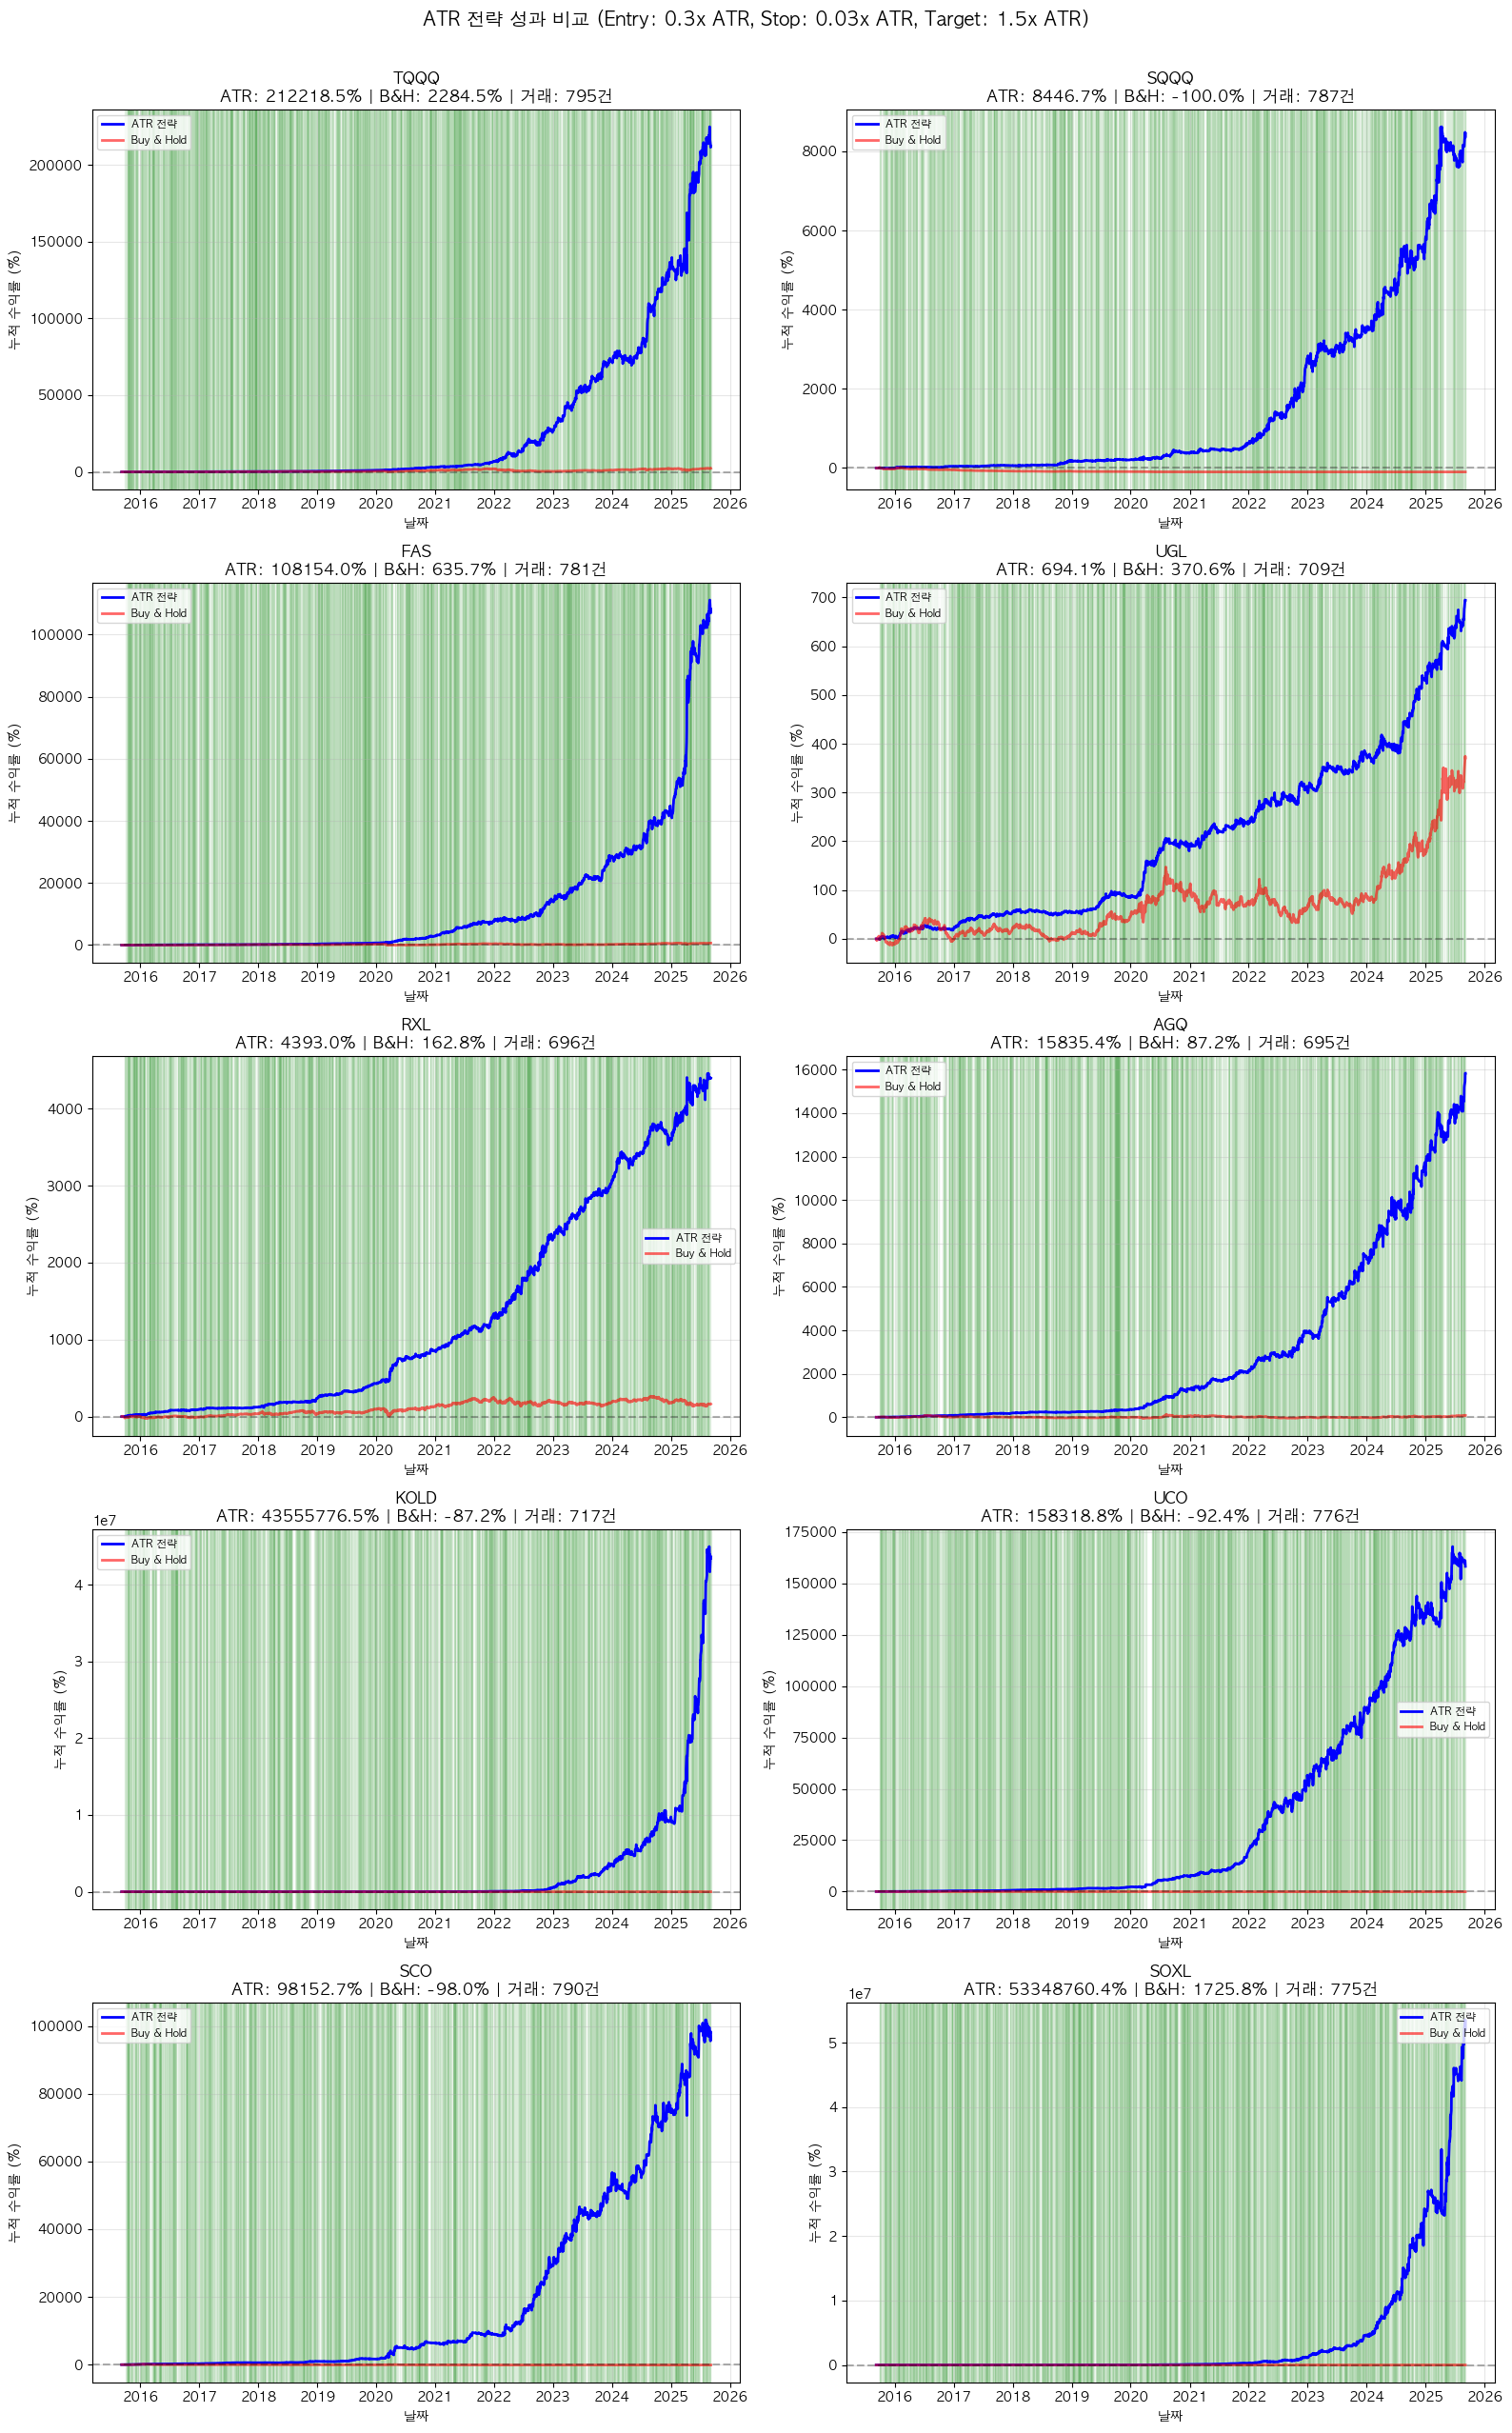


=== 전체 종목 성과 요약 ===
  종목   ATR 전략(%)  Buy&Hold(%)  ATR CAGR(%)  B&H CAGR(%)      초과수익(%)  거래횟수  승률(%)  MDD(%)  샤프비율  소르티노
SOXL 53348760.43      1725.82       274.26        33.74   2921813.62   775   22.2   -30.6  2.52  3.20
KOLD 43555776.47       -87.21       266.81       -18.60 340452581.97   717   21.9   -24.7  2.63  3.86
TQQQ   212218.48      2284.49       115.29        37.36      8804.16   795   19.9   -21.8  1.99  2.48
 UCO   158318.83       -92.38       109.03       -22.72   2080138.65   776   18.4   -22.2  2.01  2.75
 FAS   108153.95       635.73       101.21        22.11     14613.90   781   20.5   -21.5  2.06  2.65
 SCO    98152.68       -98.00        99.31       -32.38   4900566.21   790   17.7   -37.2  1.64  2.37
 AGQ    15835.41        87.18        66.13         6.48      8413.51   695   20.6   -11.4  1.88  2.69
SQQQ     8446.70       -99.96        56.09       -53.84  19299335.96   787   14.6   -17.0  1.30  1.68
 RXL     4393.00       162.81        46.33        10.15      

In [143]:
# 3-2. 모든 종목의 성과 비교 그래프
# 각 종목에 대해 portfolio_df 재생성
portfolio_results = {}
for ticker, df in stock_data.items():
    trades_df, portfolio_df = backtest_atr_strategy(
        ticker, df, initial_capital,
        atr_entry_multiplier=atr_entry_multiplier,
        stop_loss_atr=stop_loss_atr,
        take_profit_atr=take_profit_atr,
        position_sizing=position_sizing,
        capital_ratio=capital_ratio
    )
    portfolio_results[ticker] = portfolio_df

# 그래프 생성
n_tickers = len(portfolio_results)
n_cols = 2
n_rows = (n_tickers + 1) // 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

for idx, (ticker, portfolio_df) in enumerate(portfolio_results.items()):
    if idx < len(axes):
        ax = axes[idx]
        
        # ATR 전략 누적 수익률
        ax.plot(portfolio_df.index, (portfolio_df['cumulative_returns'] - 1) * 100, 
                label='ATR 전략', linewidth=2, color='blue')
        
        # Buy & Hold
        ax.plot(portfolio_df.index, (portfolio_df['buy_hold_returns'] - 1) * 100, 
                label='Buy & Hold', linewidth=2, color='red', alpha=0.6)
        
        # 최종 수익률 계산
        atr_final = (portfolio_df['cumulative_returns'].iloc[-1] - 1) * 100
        bh_final = (portfolio_df['buy_hold_returns'].iloc[-1] - 1) * 100
        
        # 거래 횟수 계산
        n_trades = all_results[ticker]['total_trades']
        
        ax.set_title(f'{ticker}\nATR: {atr_final:.1f}% | B&H: {bh_final:.1f}% | 거래: {n_trades}건', 
                    fontsize=12, fontweight='bold')
        ax.set_xlabel('날짜')
        ax.set_ylabel('누적 수익률 (%)')
        ax.legend(loc='best', fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
        
        # 포지션 보유 기간 표시 (배경색)
        in_position = portfolio_df['position'] > 0
        for i in range(len(portfolio_df) - 1):
            if in_position.iloc[i]:
                ax.axvspan(portfolio_df.index[i], portfolio_df.index[i+1], 
                          alpha=0.1, color='green')

# 빈 서브플롯 숨기기
for idx in range(len(portfolio_results), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.suptitle(f'ATR 전략 성과 비교 (Entry: {atr_entry_multiplier}x ATR, Stop: {stop_loss_atr}x ATR, Target: {take_profit_atr}x ATR)', 
             y=1.02, fontsize=14)
plt.show()

# 전체 성과 요약 테이블
summary_data = []
for ticker, results in all_results.items():
    portfolio_df = portfolio_results[ticker]
    
    # Buy & Hold CAGR 계산
    start_date = portfolio_df.index[0]
    end_date = portfolio_df.index[-1]
    years = (end_date - start_date).days / 365.25
    bh_cagr = (portfolio_df['buy_hold_returns'].iloc[-1]) ** (1 / years) - 1
    
    summary_data.append({
        '종목': ticker,
        'ATR 전략(%)': round((portfolio_df['cumulative_returns'].iloc[-1] - 1) * 100, 2),
        'Buy&Hold(%)': round((portfolio_df['buy_hold_returns'].iloc[-1] - 1) * 100, 2),
        'ATR CAGR(%)': round(results['cagr'] * 100, 2),
        'B&H CAGR(%)': round(bh_cagr * 100, 2),
        '초과수익(%)': round((portfolio_df['strategy_vs_buyhold'].iloc[-1] - 1) * 100, 2),
        '거래횟수': results['total_trades'],
        '승률(%)': round(results.get('win_rate', 0) * 100, 1),
        'MDD(%)': round(results['max_drawdown'] * 100, 1),
        '샤프비율': round(results['sharpe_ratio'], 2),
        '소르티노': round(results.get('sortino_ratio', 0), 2)
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('ATR 전략(%)', ascending=False)

print("\n=== 전체 종목 성과 요약 ===")
print(summary_df.to_string(index=False))

# 평균 성과 계산
print(f"\n=== 평균 성과 ===")
print(f"평균 ATR 전략 수익률: {summary_df['ATR 전략(%)'].mean():.2f}%")
print(f"평균 Buy&Hold 수익률: {summary_df['Buy&Hold(%)'].mean():.2f}%")
print(f"평균 ATR CAGR: {summary_df['ATR CAGR(%)'].mean():.2f}%")
print(f"평균 Buy&Hold CAGR: {summary_df['B&H CAGR(%)'].mean():.2f}%")
print(f"평균 초과 수익률: {summary_df['초과수익(%)'].mean():.2f}%")
print(f"평균 거래 횟수: {summary_df['거래횟수'].mean():.1f}")
print(f"평균 승률: {summary_df['승률(%)'].mean():.1f}%")
print(f"평균 샤프비율: {summary_df['샤프비율'].mean():.2f}")
print(f"평균 소르티노비율: {summary_df['소르티노'].mean():.2f}")

# 샤프비율과 소르티노비율 비교
print(f"\n=== 위험조정 수익률 비교 ===")
for ticker in summary_df['종목']:
    sharpe = all_results[ticker]['sharpe_ratio']
    sortino = all_results[ticker].get('sortino_ratio', 0)
    cagr = all_results[ticker]['cagr']
    print(f"{ticker}: 샤프 {sharpe:.2f} | 소르티노 {sortino:.2f} | 차이 {sortino-sharpe:.2f} | CAGR {cagr:.1%}")

### 6.1. 통합 결과 시각화

=== 포트폴리오 통합 백테스트 ===
종목 수: 10개
초기 자본: $100,000

1. 균등 배분 포트폴리오

통합 포트폴리오 성과:
- 최종 포트폴리오 가치: $9,668,213,913.60
- 총 수익률: 9668113.91%
- CAGR: 215.51%
- 샤프 비율: 3.15
- 소르티노 비율: 3.58
- 최대 낙폭: -16.63%
- 총 거래 수: 7347

=== 통합 포트폴리오 vs 개별 종목 성과 ===
구분                       수익률     CAGR       샤프비율        MDD
------------------------------------------------------------
균등배분 포트........  9668113.9%  215.5%       3.15    -16.6%
TQQQ...........   212218.5%  115.3%       1.99    -21.8%
SQQQ...........     8446.7%   56.1%       1.30    -17.0%
FAS............   107937.3%  101.2%       2.06    -21.5%
UGL............      694.1%   23.0%       1.27     -8.3%
RXL............     4384.0%   46.3%       1.91     -9.9%
AGQ............    15835.4%   66.1%       1.88    -11.4%
KOLD........... 43555776.5%  266.8%       2.63    -24.7%
UCO............   158001.8%  109.0%       2.01    -22.2%
SCO............    98152.7%   99.3%       1.64    -37.2%
SOXL........... 53242012.3%  274.3%       2.52    -30.6%

Buy&Hold 포트

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
/var/folders/v3/2dpbvf1x3v77928twwzc9jq80000gn/T/ipykernel_49588/2866541814.py:259: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  trades_monthly = integrated_trades.set_index('entry_date').resample('M').size()
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


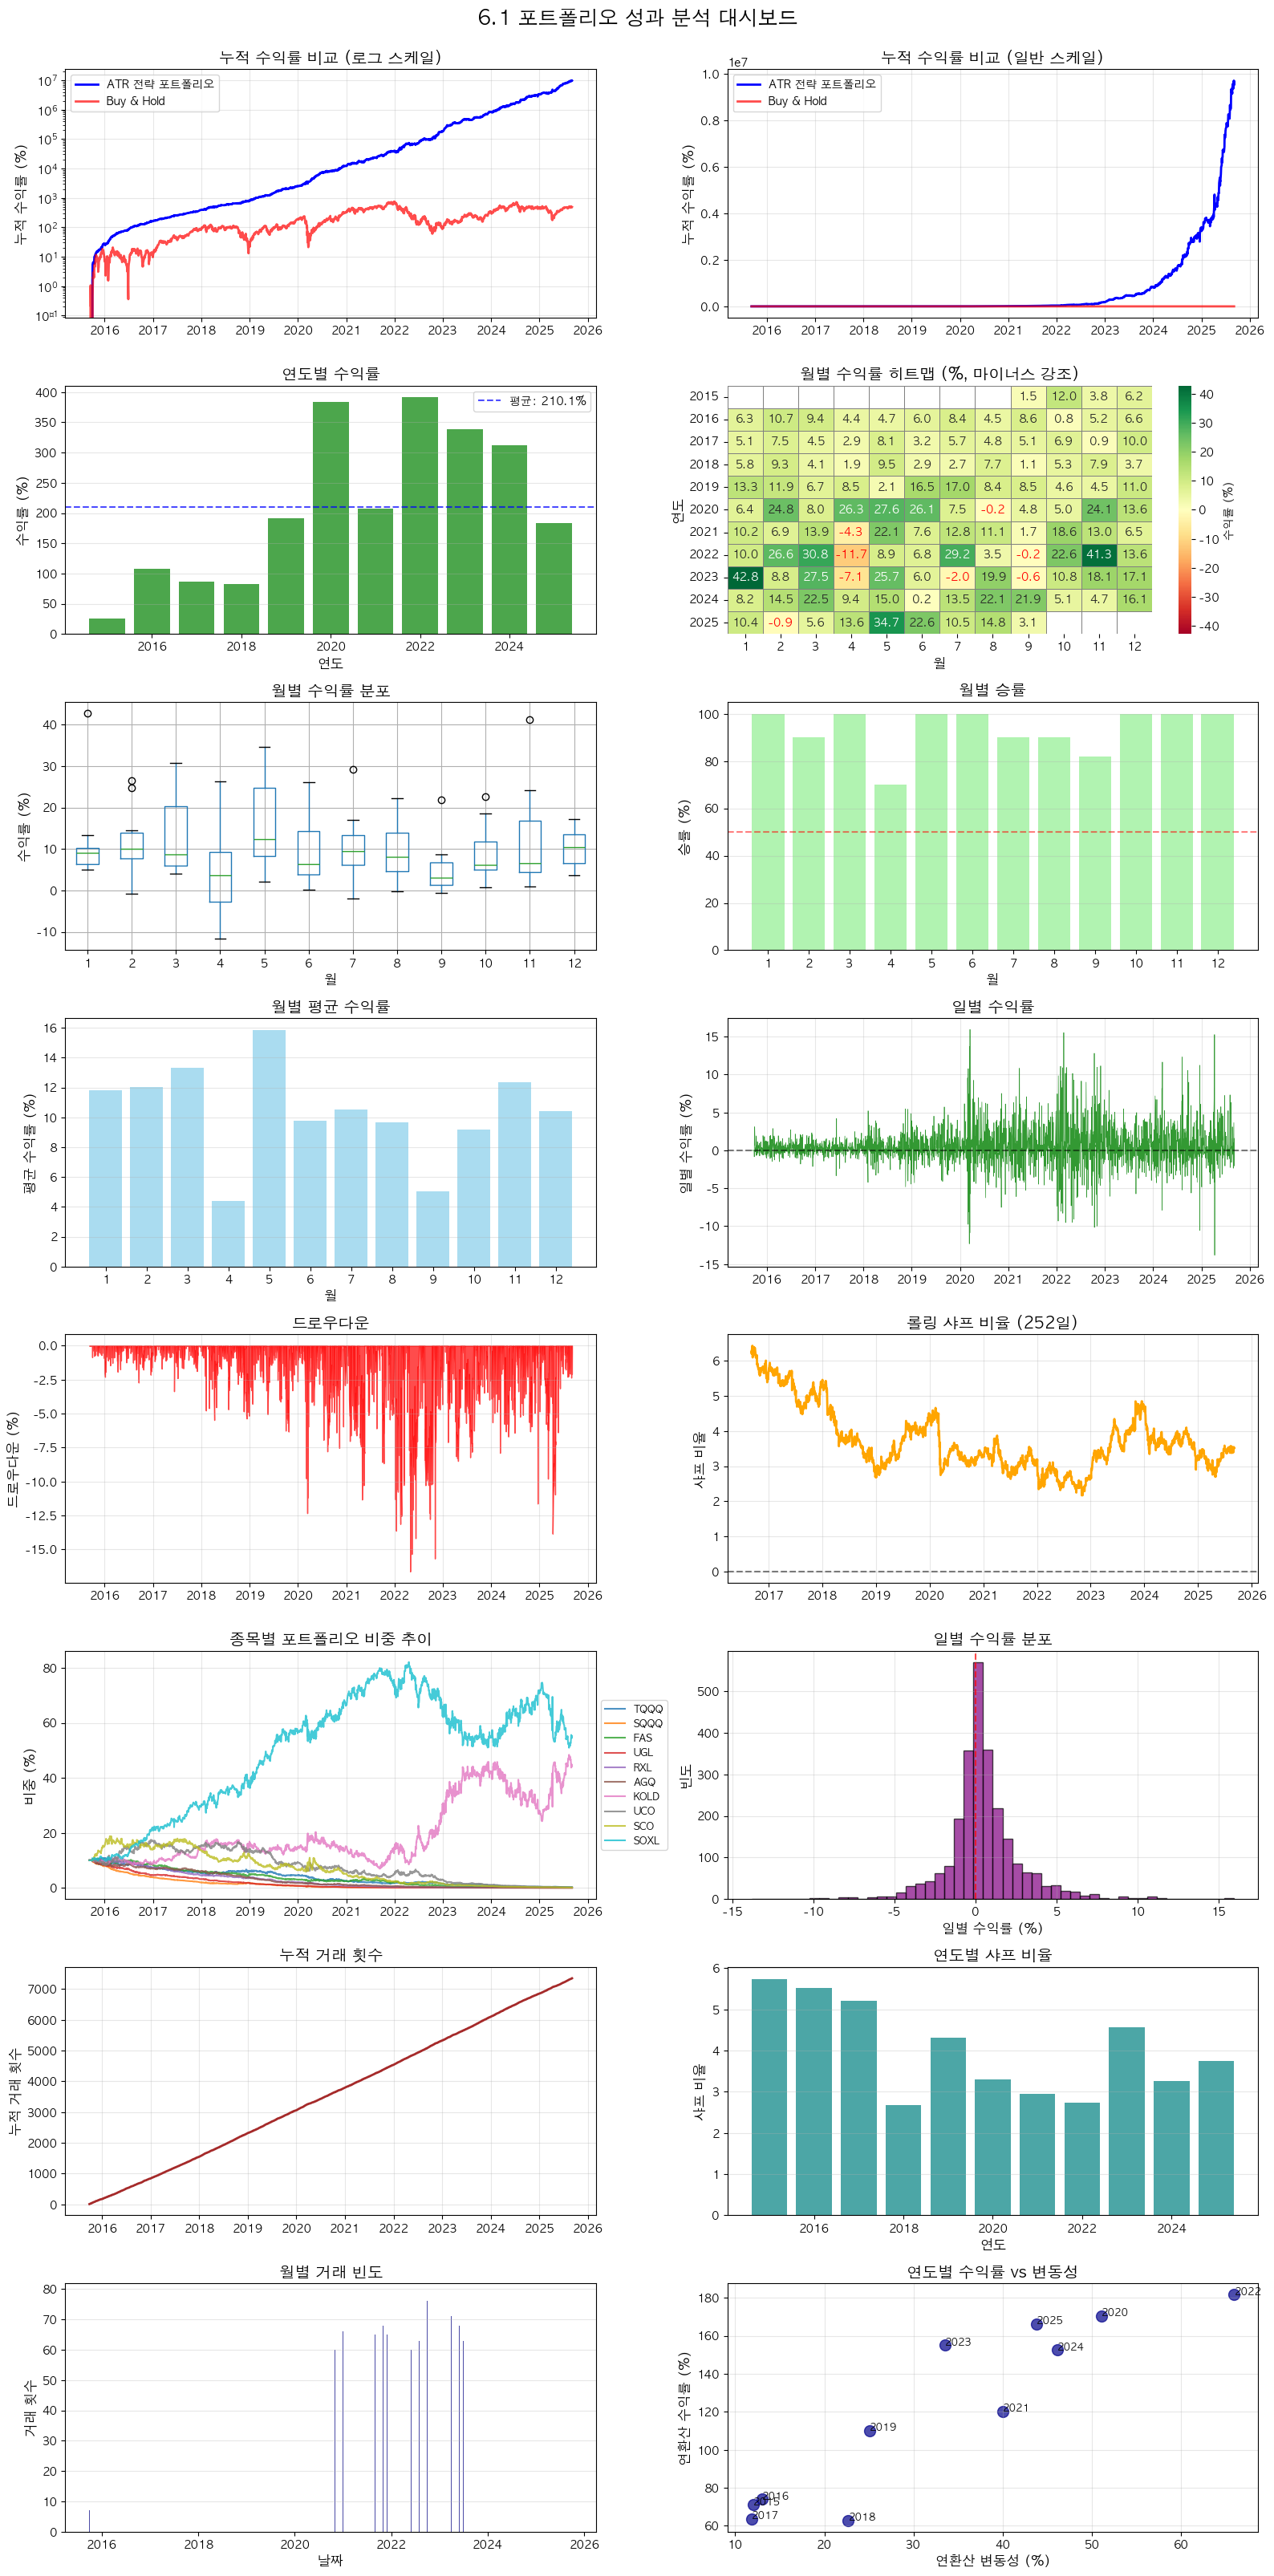

In [168]:
# 포트폴리오 통합 백테스트 실행 및 시각화 추가
print("=== 포트폴리오 통합 백테스트 ===")
print(f"종목 수: {len(stock_data)}개")
print(f"초기 자본: ${initial_capital:,}")

# 균등 배분 포트폴리오
print("\n1. 균등 배분 포트폴리오")
integrated_trades, integrated_portfolio, ticker_results, integrated_results = portfolio_integrated_backtest(
    stock_data,
    initial_capital=initial_capital,
    atr_entry_multiplier=atr_entry_multiplier,
    stop_loss_atr=stop_loss_atr,
    take_profit_atr=take_profit_atr,
    allocation_method='equal',
    capital_ratio=capital_ratio,
    position_sizing=position_sizing
)

print(f"\n통합 포트폴리오 성과:")
print(f"- 최종 포트폴리오 가치: ${integrated_results['final_portfolio_value']:,.2f}")
print(f"- 총 수익률: {integrated_results['total_return']:.2%}")
print(f"- CAGR: {integrated_results['cagr']:.2%}")
print(f"- 샤프 비율: {integrated_results['sharpe_ratio']:.2f}")
print(f"- 소르티노 비율: {integrated_results.get('sortino_ratio', 0):.2f}")
print(f"- 최대 낙폭: {integrated_results['max_drawdown']:.2%}")
print(f"- 총 거래 수: {integrated_results['total_trades']}")

# 종목별 할당 비중 출력
# print(f"\n종목별 자본 할당:")
# for ticker, results in ticker_results.items():
#     allocation = results['allocation']
#     print(f"- {ticker}: {allocation:.1%} (${allocation * initial_capital:,.0f})")

# 통합 포트폴리오 vs 개별 종목 성과 비교
print("\n=== 통합 포트폴리오 vs 개별 종목 성과 ===")
print(f"{'구분':<15} {'수익률':>12} {'CAGR':>8} {'샤프비율':>10} {'MDD':>10}")
print("-" * 60)

# 통합 포트폴리오
print(f"{'균등배분 포트':.<15} {integrated_results['total_return']:>11.1%} {integrated_results['cagr']:>7.1%} {integrated_results['sharpe_ratio']:>10.2f} {integrated_results['max_drawdown']:>9.1%}")

# 개별 종목
for ticker, results in all_results.items():
    print(f"{ticker:.<15} {results['total_return']:>11.1%} {results['cagr']:>7.1%} {results['sharpe_ratio']:>10.2f} {results['max_drawdown']:>9.1%}")

# Buy & Hold 포트폴리오와 비교
bh_return = (integrated_portfolio['buy_hold_returns'].iloc[-1] - 1)
# Buy & Hold CAGR 계산
start_date = integrated_portfolio.index[0]
end_date = integrated_portfolio.index[-1]
years = (end_date - start_date).days / 365.25
bh_cagr = (1 + bh_return) ** (1 / years) - 1

print(f"\n{'Buy&Hold 포트':.<15} {bh_return:>11.1%} {bh_cagr:>7.1%}")

print(f"\n포트폴리오 초과 수익률:")
print(f"- 균등배분: {integrated_results['total_return'] - bh_return:.1%} (CAGR 초과: {integrated_results['cagr'] - bh_cagr:.1%})")

# 6.1 월별/연도별 수익률 계산
# 월별 수익률
integrated_portfolio['month'] = integrated_portfolio.index.to_period('M')
monthly_returns = integrated_portfolio.groupby('month')['daily_returns'].apply(lambda x: (1 + x).prod() - 1) * 100

# 연도별 수익률
integrated_portfolio['year'] = integrated_portfolio.index.year
yearly_returns = integrated_portfolio.groupby('year')['daily_returns'].apply(lambda x: (1 + x).prod() - 1) * 100

# 6.1 8x2 그래프 생성 (16개 차트)
fig, axes = plt.subplots(8, 2, figsize=(16, 32))
axes = axes.flatten()

# 1. 누적수익률 그래프 (로그스케일)
ax1 = axes[0]
ax1.plot(integrated_portfolio.index, (integrated_portfolio['cumulative_returns'] - 1) * 100, 
         label='ATR 전략 포트폴리오', linewidth=2, color='blue')
ax1.plot(integrated_portfolio.index, (integrated_portfolio['buy_hold_returns'] - 1) * 100, 
         label='Buy & Hold', linewidth=2, color='red', alpha=0.7)
ax1.set_yscale('log')
ax1.set_ylabel('누적 수익률 (%)', fontsize=12)
ax1.set_title('누적 수익률 비교 (로그 스케일)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# 2. 누적수익률 (비로그 스케일)
ax16 = axes[1]
ax16.plot(integrated_portfolio.index, (integrated_portfolio['cumulative_returns'] - 1) * 100, 
         label='ATR 전략 포트폴리오', linewidth=2, color='blue')
ax16.plot(integrated_portfolio.index, (integrated_portfolio['buy_hold_returns'] - 1) * 100, 
         label='Buy & Hold', linewidth=2, color='red', alpha=0.7)
ax16.set_ylabel('누적 수익률 (%)', fontsize=12)
ax16.set_title('누적 수익률 비교 (일반 스케일)', fontsize=14, fontweight='bold')
ax16.legend(fontsize=10)
ax16.grid(True, alpha=0.3)

# 2. 연도별 수익률 막대그래프
ax4 = axes[2]
colors = ['red' if x < 0 else 'green' for x in yearly_returns]
ax4.bar(yearly_returns.index, yearly_returns.values, color=colors, alpha=0.7)
ax4.set_xlabel('연도', fontsize=12)
ax4.set_ylabel('수익률 (%)', fontsize=12)
ax4.set_title('연도별 수익률', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')
ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# 평균선 추가
ax4.axhline(y=yearly_returns.mean(), color='blue', linestyle='--', alpha=0.7, 
            label=f'평균: {yearly_returns.mean():.1f}%')
ax4.legend(fontsize=10)

# 3. 월별 수익률 히트맵 (마이너스 강조)
ax3 = axes[3]
# 월별 수익률을 연도-월 형태의 피벗 테이블로 변환
monthly_pivot = monthly_returns.to_frame('returns')
monthly_pivot['year'] = monthly_pivot.index.year
monthly_pivot['month'] = monthly_pivot.index.month
monthly_pivot = monthly_pivot.pivot(index='year', columns='month', values='returns')

# 커스텀 색상맵 생성 - 마이너스를 더 강조
import matplotlib.colors as mcolors
# 색상 경계값 설정 (마이너스 영역을 더 넓게)
vmin = monthly_pivot.min().min()
vmax = monthly_pivot.max().max()
# 0을 중심으로 하되, 마이너스 쪽의 색상 범위를 더 강하게
if abs(vmin) > vmax:
    vmax = abs(vmin)
else:
    vmin = -vmax

# 히트맵 with 강조된 마이너스
sns.heatmap(monthly_pivot, annot=True, fmt='.1f', 
           cmap='RdYlGn',  # _r을 추가하여 색상 반전 (빨강이 마이너스)
           center=0,
           vmin=vmin, vmax=vmax,
           cbar_kws={'label': '수익률 (%)'},
           ax=ax3, 
           annot_kws={'size': 10, 'weight': 'bold'},
           linewidths=0.5,  # 셀 간 경계선 추가
           linecolor='gray')

# 마이너스 값에 대해 추가 강조 (텍스트 색상 변경)
for text in ax3.texts:
    try:
        val = float(text.get_text())
        if val < 0:
            text.set_color('red')  # 마이너스 값은 흰색 텍스트
            text.set_weight('bold')
    except:
        pass

ax3.set_title('월별 수익률 히트맵 (%, 마이너스 강조)', fontsize=14, fontweight='bold')
ax3.set_xlabel('월', fontsize=12)
ax3.set_ylabel('연도', fontsize=12)

# 4. 월별 수익률 박스플롯
ax12 = axes[4]
monthly_returns_df = monthly_returns.to_frame('returns')
monthly_returns_df['month_num'] = monthly_returns_df.index.month
monthly_returns_df.boxplot(column='returns', by='month_num', ax=ax12)
ax12.set_xlabel('월', fontsize=12)
ax12.set_ylabel('수익률 (%)', fontsize=12)
ax12.set_title('월별 수익률 분포', fontsize=14)
ax12.set_xticklabels(range(1, 13))

# 5. 월별 승률
ax7 = axes[5]
monthly_wins = monthly_returns > 0
monthly_win_rate = monthly_wins.groupby(monthly_wins.index.month).mean() * 100
ax7.bar(range(1, 13), monthly_win_rate.values, color='lightgreen', alpha=0.7)
ax7.set_xlabel('월', fontsize=12)
ax7.set_ylabel('승률 (%)', fontsize=12)
ax7.set_title('월별 승률', fontsize=14, fontweight='bold')
ax7.set_xticks(range(1, 13))
ax7.axhline(y=50, color='red', linestyle='--', alpha=0.5)
ax7.grid(True, alpha=0.3, axis='y')

# 6. 월별 평균 수익률
ax5 = axes[6]
monthly_avg = monthly_returns.groupby(monthly_returns.index.month).mean()
ax5.bar(range(1, 13), monthly_avg.values, color='skyblue', alpha=0.7)
ax5.set_xlabel('월', fontsize=12)
ax5.set_ylabel('평균 수익률 (%)', fontsize=12)
ax5.set_title('월별 평균 수익률', fontsize=14, fontweight='bold')
ax5.set_xticks(range(1, 13))
ax5.grid(True, alpha=0.3, axis='y')

# 7. 일별 수익률
ax2 = axes[7]
ax2.plot(integrated_portfolio.index, integrated_portfolio['daily_returns'] * 100, 
         linewidth=0.5, color='green', alpha=0.8)
ax2.set_ylabel('일별 수익률 (%)', fontsize=12)
ax2.set_title('일별 수익률', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# 8. 드로우다운
ax6 = axes[8]
cummax = integrated_portfolio['portfolio_value'].cummax()
drawdown = (integrated_portfolio['portfolio_value'] - cummax) / cummax * 100
ax6.fill_between(drawdown.index, drawdown, 0, alpha=0.7, color='red')
ax6.set_ylabel('드로우다운 (%)', fontsize=12)
ax6.set_title('드로우다운', fontsize=14, fontweight='bold')
ax6.grid(True, alpha=0.3)

# 9. 롤링 샤프 비율 (252일)
ax9 = axes[9]
rolling_sharpe = (integrated_portfolio['daily_returns'].rolling(252).mean() * 252) / (
    integrated_portfolio['daily_returns'].rolling(252).std() * np.sqrt(252))
ax9.plot(rolling_sharpe.index, rolling_sharpe.values, linewidth=2, color='orange')
ax9.set_ylabel('샤프 비율', fontsize=12)
ax9.set_title('롤링 샤프 비율 (252일)', fontsize=14, fontweight='bold')
ax9.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax9.grid(True, alpha=0.3)

# 10. 종목별 비중 추이
ax10 = axes[10]
for ticker in stock_data.keys():
    weight_col = f'{ticker}_weight'
    if weight_col in integrated_portfolio.columns:
        ax10.plot(integrated_portfolio.index, integrated_portfolio[weight_col] * 100, 
                 label=ticker, linewidth=1.5, alpha=0.8)
ax10.set_ylabel('비중 (%)', fontsize=12)
ax10.set_title('종목별 포트폴리오 비중 추이', fontsize=14, fontweight='bold')
ax10.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
ax10.grid(True, alpha=0.3)

# 11. 수익률 분포
ax8 = axes[11]
ax8.hist(integrated_portfolio['daily_returns'] * 100, bins=50, alpha=0.7, color='purple', edgecolor='black')
ax8.set_xlabel('일별 수익률 (%)', fontsize=12)
ax8.set_ylabel('빈도', fontsize=12)
ax8.set_title('일별 수익률 분포', fontsize=14, fontweight='bold')
ax8.axvline(x=0, color='red', linestyle='--', alpha=0.7)
ax8.grid(True, alpha=0.3)

# 12. 누적 거래 횟수
ax10 = axes[12]
if len(integrated_trades) > 0:
    trades_cumsum = integrated_trades.groupby(integrated_trades['entry_date'].dt.date).size().cumsum()
    ax10.plot(trades_cumsum.index, trades_cumsum.values, linewidth=2, color='brown')
ax10.set_ylabel('누적 거래 횟수', fontsize=12)
ax10.set_title('누적 거래 횟수', fontsize=14, fontweight='bold')
ax10.grid(True, alpha=0.3)

# 13. 연도별 샤프 비율
ax11 = axes[13]
yearly_sharpe = integrated_portfolio.groupby('year')['daily_returns'].apply(
    lambda x: (x.mean() * 252 - 0.02) / (x.std() * np.sqrt(252)) if x.std() > 0 else 0
)
ax11.bar(yearly_sharpe.index, yearly_sharpe.values, color='teal', alpha=0.7)
ax11.set_xlabel('연도', fontsize=12)
ax11.set_ylabel('샤프 비율', fontsize=12)
ax11.set_title('연도별 샤프 비율', fontsize=14, fontweight='bold')
ax11.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax11.grid(True, alpha=0.3, axis='y')

# 14. 월별 거래 빈도
ax14 = axes[14]
if len(integrated_trades) > 0:
    trades_monthly = integrated_trades.set_index('entry_date').resample('M').size()
    ax14.bar(trades_monthly.index, trades_monthly.values, color='navy', alpha=0.7)
    ax14.set_xlabel('날짜', fontsize=12)
    ax14.set_ylabel('거래 횟수', fontsize=12)
    ax14.set_title('월별 거래 빈도', fontsize=14, fontweight='bold')
    ax14.grid(True, alpha=0.3, axis='y')

# 15. 수익률 vs 변동성 산점도
ax15 = axes[15]
# 연도별 수익률과 변동성 계산
yearly_stats = integrated_portfolio.groupby('year')['daily_returns'].agg(['mean', 'std'])
yearly_stats['annual_return'] = yearly_stats['mean'] * 252
yearly_stats['annual_vol'] = yearly_stats['std'] * np.sqrt(252)

ax15.scatter(yearly_stats['annual_vol'] * 100, yearly_stats['annual_return'] * 100, 
            s=100, alpha=0.7, color='darkblue')
for year in yearly_stats.index:
    ax15.annotate(str(year), 
                 (yearly_stats.loc[year, 'annual_vol'] * 100, 
                  yearly_stats.loc[year, 'annual_return'] * 100),
                 fontsize=9)
ax15.set_xlabel('연환산 변동성 (%)', fontsize=12)
ax15.set_ylabel('연환산 수익률 (%)', fontsize=12)
ax15.set_title('연도별 수익률 vs 변동성', fontsize=14, fontweight='bold')
ax15.grid(True, alpha=0.3)



plt.tight_layout()
plt.suptitle('6.1 포트폴리오 성과 분석 대시보드', fontsize=18, fontweight='bold', y=1.002)
plt.show()

### 6.2. 상대모멘텀 전략 백테스트

=== ATR 전략 수익률 기반 상대모멘텀 포트폴리오 (다양한 설정) ===

테스트 중: 5일 모멘텀 Top3
- 모멘텀 기간: 5일
- 선택 종목 수: 3개

성과:
- 총 수익률: 723877.14%
- CAGR: 143.41%
- 샤프 비율: 3.06
- 소르티노 비율: 3.66
- 최대 낙폭: -20.59%

가장 많이 선택된 종목 Top3:
- SOXL: 56회 (46.7%)
- KOLD: 49회 (40.8%)
- TQQQ: 46회 (38.3%)

테스트 중: 10일 모멘텀 Top3
- 모멘텀 기간: 10일
- 선택 종목 수: 3개

성과:
- 총 수익률: 1066385.48%
- CAGR: 153.04%
- 샤프 비율: 3.24
- 소르티노 비율: 3.74
- 최대 낙폭: -17.52%

가장 많이 선택된 종목 Top3:
- SOXL: 63회 (52.5%)
- KOLD: 55회 (45.8%)
- SCO: 43회 (35.8%)

테스트 중: 20일 모멘텀 Top3
- 모멘텀 기간: 20일
- 선택 종목 수: 3개

성과:
- 총 수익률: 1154683.08%
- CAGR: 155.06%
- 샤프 비율: 3.18
- 소르티노 비율: 3.72
- 최대 낙폭: -20.59%

가장 많이 선택된 종목 Top3:
- SOXL: 73회 (61.3%)
- KOLD: 63회 (52.9%)
- FAS: 42회 (35.3%)

테스트 중: 20일 모멘텀 Top5
- 모멘텀 기간: 20일
- 선택 종목 수: 5개

성과:
- 총 수익률: 408656.66%
- CAGR: 129.88%
- 샤프 비율: 3.78
- 소르티노 비율: 4.47
- 최대 낙폭: -10.93%

가장 많이 선택된 종목 Top3:
- SOXL: 87회 (73.1%)
- KOLD: 75회 (63.0%)
- UCO: 69회 (58.0%)

테스트 중: 60일 모멘텀 Top3
- 모멘텀 기간: 60일
- 선택 종목 수: 3개

성과:
- 총 수익률: 2761080.86%
- CAGR: 178.31%
-

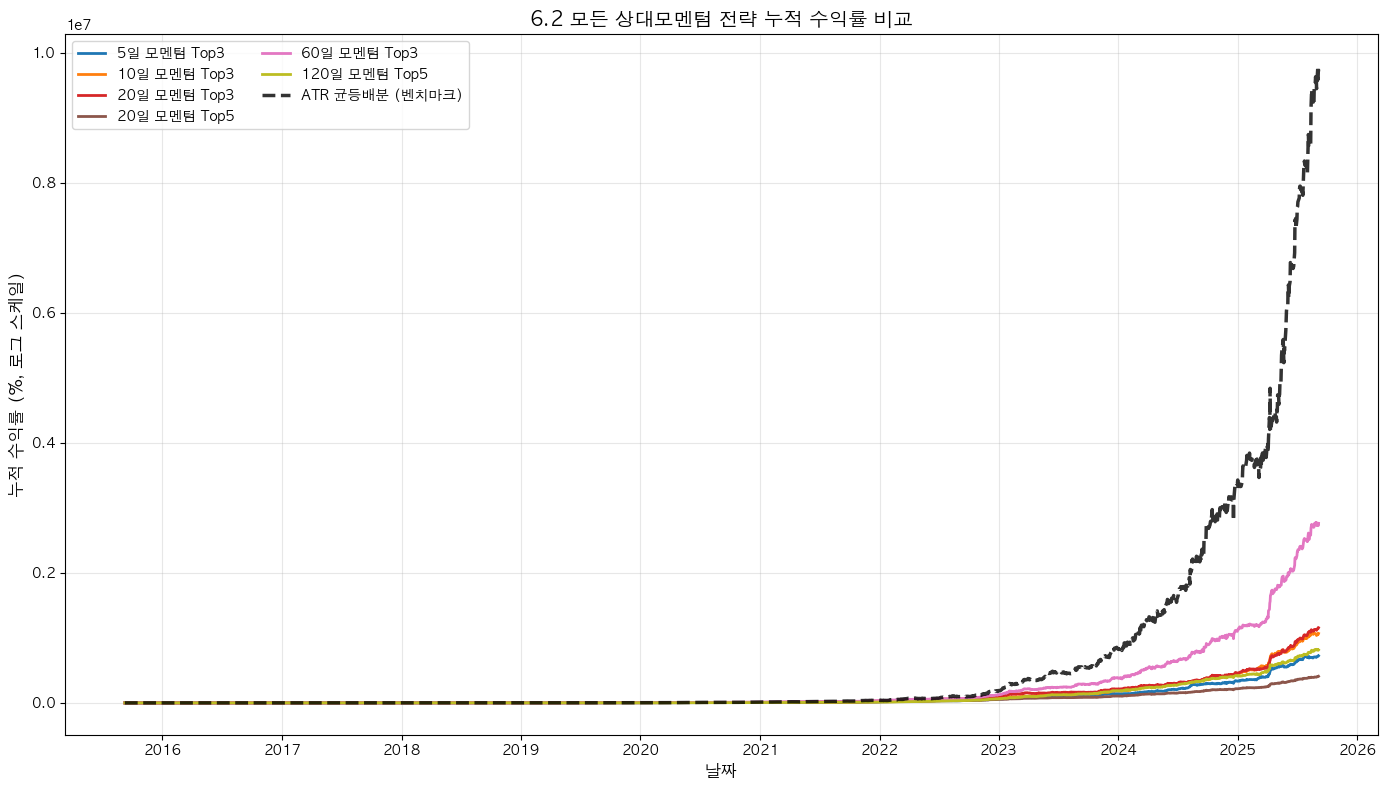

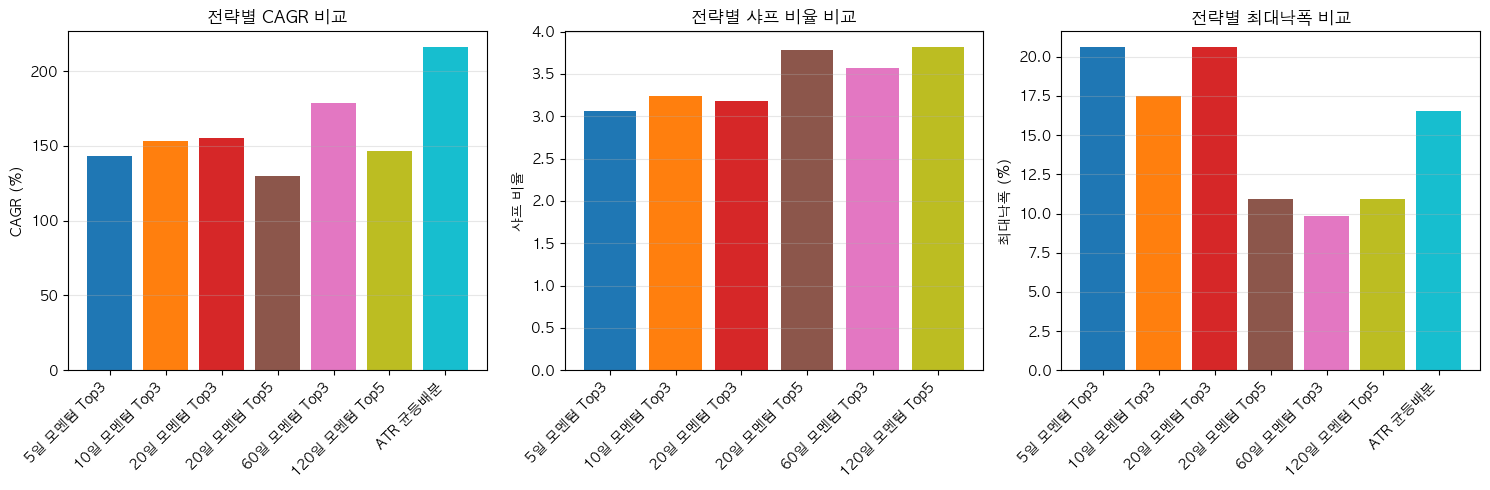

In [155]:
# ATR 전략 수익률 기반 상대모멘텀 포트폴리오 - 다양한 설정
print("=== ATR 전략 수익률 기반 상대모멘텀 포트폴리오 (다양한 설정) ===")

# 상대모멘텀 포트폴리오 - 다양한 설정
momentum_configs = [
    {'period': 5, 'top_n': 3, 'name': '5일 모멘텀 Top3'},
    {'period': 10, 'top_n': 3, 'name': '10일 모멘텀 Top3'},
    {'period': 20, 'top_n': 3, 'name': '20일 모멘텀 Top3'},
    {'period': 20, 'top_n': 5, 'name': '20일 모멘텀 Top5'},
    {'period': 60, 'top_n': 3, 'name': '60일 모멘텀 Top3'},
    {'period': 120, 'top_n': 5, 'name': '120일 모멘텀 Top5'}
]

# 리밸런싱 주기
rebalance_freq = 'monthly'

# 모든 설정에 대한 결과 저장
momentum_results_dict = {}
momentum_portfolios = {}
momentum_selected_tickers = {}
momentum_scores_history = {}

# 각 설정별로 백테스트 실행
for config in momentum_configs:
    print(f"\n{'='*50}")
    print(f"테스트 중: {config['name']}")
    print(f"- 모멘텀 기간: {config['period']}일")
    print(f"- 선택 종목 수: {config['top_n']}개")
    
    # Top N이 전체 종목 수보다 많으면 조정
    actual_top_n = min(config['top_n'], len(stock_data))
    if actual_top_n != config['top_n']:
        print(f"  → 종목 수 조정: {config['top_n']} → {actual_top_n}")
    
    # 상대모멘텀 포트폴리오 구성
    momentum_portfolio_df, selected_tickers_df, momentum_scores_df, weights_df = relative_momentum_portfolio_selection(
        all_results,
        portfolio_results,
        initial_capital=initial_capital,
        lookback_period=config['period'],
        top_n=actual_top_n,
        rebalance_freq=rebalance_freq
    )
    
    # 결과 분석
    momentum_results = analyze_backtest_results(pd.DataFrame(), momentum_portfolio_df, initial_capital)
    
    # 결과 저장
    momentum_results_dict[config['name']] = momentum_results
    momentum_portfolios[config['name']] = momentum_portfolio_df
    momentum_selected_tickers[config['name']] = selected_tickers_df
    momentum_scores_history[config['name']] = momentum_scores_df
    
    # 성과 출력
    print(f"\n성과:")
    print(f"- 총 수익률: {momentum_results['total_return']:.2%}")
    print(f"- CAGR: {momentum_results['cagr']:.2%}")
    print(f"- 샤프 비율: {momentum_results['sharpe_ratio']:.2f}")
    print(f"- 소르티노 비율: {momentum_results.get('sortino_ratio', 0):.2f}")
    print(f"- 최대 낙폭: {momentum_results['max_drawdown']:.2%}")
    
    # 종목별 선택 빈도
    if not selected_tickers_df.empty:
        ticker_count = {}
        for _, row in selected_tickers_df.iterrows():
            for ticker in row.dropna():
                ticker_count[ticker] = ticker_count.get(ticker, 0) + 1
        
        print(f"\n가장 많이 선택된 종목 Top3:")
        sorted_tickers = sorted(ticker_count.items(), key=lambda x: x[1], reverse=True)[:3]
        for ticker, count in sorted_tickers:
            selection_rate = count / len(selected_tickers_df) * 100
            print(f"- {ticker}: {count}회 ({selection_rate:.1f}%)")

# 전체 결과 요약 테이블
print(f"\n{'='*80}")
print("=== 모든 상대모멘텀 전략 성과 요약 ===")

summary_data = []
for name, results in momentum_results_dict.items():
    summary_data.append({
        '전략': name,
        '수익률(%)': round(results['total_return'] * 100, 2),
        'CAGR(%)': round(results['cagr'] * 100, 2),
        'MDD(%)': round(results['max_drawdown'] * 100, 2),
        '샤프': round(results['sharpe_ratio'], 2),
        '소르티노': round(results.get('sortino_ratio', 0), 2)
    })

# ATR 균등배분 벤치마크 추가
bh_portfolio = momentum_portfolios[list(momentum_portfolios.keys())[0]]  # 아무 포트폴리오에서 벤치마크 가져오기
bh_return = (bh_portfolio['buy_hold_returns'].iloc[-1] - 1)
bh_years = (bh_portfolio.index[-1] - bh_portfolio.index[0]).days / 365.25
bh_cagr = (1 + bh_return) ** (1 / bh_years) - 1

# 벤치마크 MDD 계산을 위해 균등배분 포트폴리오 생성
equal_weight_values = []
for date in bh_portfolio.index:
    daily_value = 0
    for ticker, portfolio_df in portfolio_results.items():
        if date in portfolio_df.index:
            daily_value += portfolio_df.loc[date, 'portfolio_value'] / len(portfolio_results)
    equal_weight_values.append(daily_value)

equal_weight_df = pd.DataFrame({'value': equal_weight_values}, index=bh_portfolio.index)
cummax = equal_weight_df['value'].cummax()
drawdown = (equal_weight_df['value'] - cummax) / cummax
bh_mdd = drawdown.min()

summary_data.append({
    '전략': 'ATR 균등배분 (벤치마크)',
    '수익률(%)': round(bh_return * 100, 2),
    'CAGR(%)': round(bh_cagr * 100, 2),
    'MDD(%)': round(bh_mdd * 100, 2),
    '샤프': '-',
    '소르티노': '-'
})

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# 최고 성과 전략 찾기
best_cagr_strategy = max(momentum_results_dict.items(), key=lambda x: x[1]['cagr'])[0]
best_sharpe_strategy = max(momentum_results_dict.items(), key=lambda x: x[1]['sharpe_ratio'])[0]
best_mdd_strategy = min(momentum_results_dict.items(), key=lambda x: abs(x[1]['max_drawdown']))[0]

print(f"\n=== 최고 성과 전략 ===")
print(f"- 최고 CAGR: {best_cagr_strategy}")
print(f"- 최고 샤프비율: {best_sharpe_strategy}")
print(f"- 최저 MDD: {best_mdd_strategy}")

# 6.2 모든 모멘텀 전략 누적 수익률 그래프 (로그 스케일)
plt.figure(figsize=(14, 8))

# 색상 팔레트
colors = plt.cm.tab10(np.linspace(0, 1, len(momentum_portfolios) + 1))

# 각 모멘텀 전략의 누적 수익률 그리기
for i, (name, portfolio_df) in enumerate(momentum_portfolios.items()):
    plt.plot(portfolio_df.index, (portfolio_df['cumulative_returns'] - 1) * 100, 
             label=name, linewidth=2, color=colors[i])

# 벤치마크 (ATR 균등배분) 추가
plt.plot(bh_portfolio.index, (bh_portfolio['buy_hold_returns'] - 1) * 100, 
         label='ATR 균등배분 (벤치마크)', linewidth=2.5, color='black', 
         linestyle='--', alpha=0.8)

# plt.yscale('log')
plt.xlabel('날짜', fontsize=12)
plt.ylabel('누적 수익률 (%, 로그 스케일)', fontsize=12)
plt.title('6.2 모든 상대모멘텀 전략 누적 수익률 비교', fontsize=14, fontweight='bold')
plt.legend(loc='upper left', fontsize=10, ncol=2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 추가: 전략별 성과 비교 막대 그래프
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# CAGR 비교
ax1 = axes[0]
strategies = list(momentum_results_dict.keys()) + ['ATR 균등배분']
cagrs = [momentum_results_dict[s]['cagr'] * 100 for s in list(momentum_results_dict.keys())] + [bh_cagr * 100]
ax1.bar(range(len(strategies)), cagrs, color=colors[:len(strategies)])
ax1.set_xticks(range(len(strategies)))
ax1.set_xticklabels(strategies, rotation=45, ha='right')
ax1.set_ylabel('CAGR (%)')
ax1.set_title('전략별 CAGR 비교')
ax1.grid(True, alpha=0.3, axis='y')

# 샤프 비율 비교
ax2 = axes[1]
sharpes = [momentum_results_dict[s]['sharpe_ratio'] for s in list(momentum_results_dict.keys())]
ax2.bar(range(len(list(momentum_results_dict.keys()))), sharpes, 
        color=colors[:len(list(momentum_results_dict.keys()))])
ax2.set_xticks(range(len(list(momentum_results_dict.keys()))))
ax2.set_xticklabels(list(momentum_results_dict.keys()), rotation=45, ha='right')
ax2.set_ylabel('샤프 비율')
ax2.set_title('전략별 샤프 비율 비교')
ax2.grid(True, alpha=0.3, axis='y')

# MDD 비교
ax3 = axes[2]
mdds = [abs(momentum_results_dict[s]['max_drawdown']) * 100 for s in list(momentum_results_dict.keys())] + [abs(bh_mdd) * 100]
ax3.bar(range(len(strategies)), mdds, color=colors[:len(strategies)])
ax3.set_xticks(range(len(strategies)))
ax3.set_xticklabels(strategies, rotation=45, ha='right')
ax3.set_ylabel('최대낙폭 (%)')
ax3.set_title('전략별 최대낙폭 비교')
ax3.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 6. 최적 파라미터 탐색

In [151]:
# 파라미터 그리드 설정
param_grid = {
    'atr_entry': [0.3, 0.5, 0.7, 0.9, 1],
    'stop_loss': [0.03, 0.05, 0.1, 0.15],
    'take_profit': [1.1, 1.2, 1.3, 1.4, 1.5, 2.0, 3.0, 4.0, 5.0]
}

# 첫 번째 종목으로 파라미터 테스트
test_ticker = list(stock_data.keys())[0]
test_df = stock_data[test_ticker]

print(f"\n{test_ticker} 종목으로 파라미터 최적화 진행...")

best_params = None
best_sharpe = -float('inf')
param_results = []

for atr_entry in param_grid['atr_entry']:
    for stop_loss in param_grid['stop_loss']:
        for take_profit in param_grid['take_profit']:
            # 손절선이 익절선보다 큰 경우는 스킵
            if stop_loss >= take_profit:
                continue
            
            # 백테스트 실행
            trades_df, portfolio_df = backtest_atr_strategy(
                test_ticker, test_df, initial_capital,
                atr_entry_multiplier=atr_entry,
                stop_loss_atr=stop_loss,
                take_profit_atr=take_profit
            )
            
            # 결과 분석
            results = analyze_backtest_results(trades_df, portfolio_df, initial_capital)
            
            param_results.append({
                'atr_entry': atr_entry,
                'stop_loss': stop_loss,
                'take_profit': take_profit,
                'total_return': results['total_return'],
                'sharpe_ratio': results['sharpe_ratio'],
                'max_drawdown': results['max_drawdown'],
                'total_trades': results['total_trades'],
                'win_rate': results.get('win_rate', 0)
            })
            
            # 최적 파라미터 업데이트 (샤프비율 기준)
            if results['sharpe_ratio'] > best_sharpe:
                best_sharpe = results['sharpe_ratio']
                best_params = {
                    'atr_entry': atr_entry,
                    'stop_loss': stop_loss,
                    'take_profit': take_profit,
                    'results': results
                }

# 결과 DataFrame 생성 및 정렬
param_results_df = pd.DataFrame(param_results)
param_results_df = param_results_df.sort_values('sharpe_ratio', ascending=False)

print("\n=== 최적 파라미터 ===")
print(f"ATR 진입 배수: {best_params['atr_entry']}")
print(f"손절선 ATR 배수: {best_params['stop_loss']}")
print(f"익절선 ATR 배수: {best_params['take_profit']}")
print(f"\n성과:")
print(f"- 수익률: {best_params['results']['total_return']:.2%}")
print(f"- 샤프비율: {best_params['results']['sharpe_ratio']:.2f}")
print(f"- 최대낙폭: {best_params['results']['max_drawdown']:.2%}")
print(f"- 승률: {best_params['results'].get('win_rate', 0):.2%}")

# 상위 10개 파라미터 조합 출력
print("\n=== 상위 10개 파라미터 조합 ===")
print(param_results_df.head(10).to_string(index=False))


TQQQ 종목으로 파라미터 최적화 진행...

=== 최적 파라미터 ===
ATR 진입 배수: 0.3
손절선 ATR 배수: 0.03
익절선 ATR 배수: 1.5

성과:
- 수익률: 5070.08%
- 샤프비율: 1.90
- 최대낙폭: -11.45%
- 승률: 19.87%

=== 상위 10개 파라미터 조합 ===
 atr_entry  stop_loss  take_profit  total_return  sharpe_ratio  max_drawdown  total_trades  win_rate
       0.3       0.03          1.5     50.700796      1.900393     -0.114500           795  0.198742
       0.3       0.03          1.4     44.556010      1.847171     -0.114499           808  0.207921
       0.3       0.03          3.0     76.388655      1.844809     -0.156067           603  0.140962
       0.5       0.03          1.5     22.488566      1.837550     -0.116677           601  0.207987
       0.5       0.05          3.0     41.971914      1.815633     -0.150862           458  0.155022
       0.5       0.05          1.5     21.628689      1.812706     -0.120178           593  0.219224
       0.3       0.05          1.5     42.915410      1.809640     -0.122351           786  0.206107
       0.5    